#### Integrin

## setup

In [1]:
import os
import sys
import math
import time
import pickle
import copy
#import mdtraj
import MDAnalysis as mda
#import pyemma
#import pyemma.util.contexts
import networkx as nx
import random
#import parmed as pmd
#import acpype
import pandas as pd
from MDAnalysis.analysis import distances
from MDAnalysis.analysis import rms


import numpy as np
from scipy.linalg import eigh
from scipy.spatial.distance import pdist
from scipy.interpolate import interp1d
import matplotlib as mpl
from matplotlib import ticker
if os.environ.get('DISPLAY','') == '':
    print('no display found. Using non-interactive Agg backend')
    mpl.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


import nglview as nv

import glob

no display found. Using non-interactive Agg backend


In [2]:

from importlib import reload 
import sys


#### plot settings

In [3]:
showPlots=1
useMagics=1
if useMagics:
    %matplotlib inline
    #%matplotlib notebook
    %load_ext autoreload
    %autoreload 2
    %reload_ext autoreload
    
font = {'weight' : 'normal',
        'size'   : 25}

plt.rc('font', **font)

## load structures

In [4]:


path_to_structures = '/project2/andrewferguson/sivadasetty/doe/analysis-integrin/string_mechanisms/deadbolt/string_parallel_100k_full_lipid_case/final_string/'


cryst_structs=['1tye','1tye_2','1tye_3', '2vc2','2vdk','2vdl','2vdm','2vdn','2vdo','2vdp','2vdq','2vdr',
               '3fcs','3fcs_2','3fcu','3fcu_2','3fcu_3',
               '3nid','3nid_2','3nif','3nif_2','3nig','3nig_2',
               '3t3m','3t3m_2','3t3p','3t3p_2',
               '3zdx','3zdx_2','3zdy','3zdy_2','3zdz','3ze0',
               '3ze1','3ze2','3zdz_2','3ze0_2','3ze1_2','3ze2_2',
               '4z7n','4z7n_2','4z7o','4z7o_2','4z7q','4z7q_2',
               '5hdb','5hdb_2',
               '7tct','7tct_2','7td8','7td8_2','7tho','7tho_2',
               '7tmz','7tmz_2','7tpd','7tpd_2','7u60','7u60_2','7u9f',
               '7u9f_2','7u9v','7u9v_2','7ubr','7ubr_2','7ucy','7ucy_2',
               '7udg','7udg_2','7udh','7udh_2','7ue0','7ue0_2','7ufh',
               '7ufh_2','7uh8','7uh8_2','7uje','7uje_2','7ujk','7ujk_2',
               '7uk9','7uk9_2','7uko','7uko_2','7ukp','7ukp_2','7ukt','7ukt_2']


#'4cak', 
cryo_structs = ['4cak','8gcd', '8gcd_2', '8gce', 
                '8t2u','8t2v', '6v4p', '7la4']

nmr_structs_cryo_likenames=['7l8p','7l8p_2']
          
#'3m10', 
nmr_structs=['1dpk', '1dpq', '1kup','1kuz', '1s4w', '1m8o', 
             '2k1a', '2k9j', '2knc', '2mtp', '2n9y', '7kn0', '7sft']


len(cryst_structs), len(cryo_structs), len(nmr_structs), len (nmr_structs_cryo_likenames)



(89, 8, 13, 2)

## Calculate pairwise distances between critical domains

In [5]:

# Domain composition alpha IIb:
# beta propeller: 1-452
# Thigh: 453-608
# Calf-1: 609-743
# Calf-2: 744-964
# Transmembrane: 965-1008

# Domain composition  Beta 3:
# beta I: residue 110-352
# Hyb: residue 58-109 + 353-432
# Psi: residue 1-57
# E1: 433-475
# E2: 476-525
# E3: 526-560
# E4: 561-604
# beta-T: 605-690
# Transmembrane: 691-772


final_string_distances_between_domains = {}
final_string_universe_image = {}

for images in range(19):
    

    # Check if exp file exists; not checking for string; if one is not present; repeat for both.
    if os.path.exists(path_to_structures+'/PDBstructures_2/distance_analysis/'+'only_final_string_iter147_dist_results_image'+str(images)+'.pkl'):
        print(f"Image {images} exists")
            
        with open(path_to_structures+'/PDBstructures_2/distance_analysis/'+'only_final_string_iter147_dist_results_image'+str(images)+'.pkl', 'rb') as input_file:     
            final_string_distances_between_domains[images] = pickle.load(input_file)
    
        
    else:
        print(f"Image {images} does not exist")

        final_string_struct = path_to_structures+'/iter147/target_md_'+str(images)+'/minimize-protein.pdb'
        final_string_universe = mda.Universe(final_string_struct) 
        final_string_universe_image[images] = final_string_universe
            
        final_string_distances_domains_string_pdb = {}   
        
        mduniverse = final_string_universe_image[images] 
                
        #print(mduniverse.select_atoms('segid is A').atoms.select_atoms('resid 1 to 452'))
    
        beta_propeller = mduniverse.select_atoms('segid is A and name is CA').atoms.select_atoms('resid 1 to 452')
        thigh = mduniverse.select_atoms('segid is A  and name is CA').atoms.select_atoms('resid 453 to 608')
        calf_1 = mduniverse.select_atoms('segid is A and name is CA ').atoms.select_atoms('resid 609 to 743')
        calf_2 = mduniverse.select_atoms('segid is A and name is CA').atoms.select_atoms('resid 744 to 964')
        alpha_transmembrane = mduniverse.select_atoms('segid is A and name is CA').atoms.select_atoms('resid 965 to 1008')

        beta_1 = mduniverse.select_atoms('segid is B and name is CA').atoms.select_atoms('resid 110 to 352')
        hyb = mduniverse.select_atoms('segid is B and name is CA').atoms.select_atoms('resid 58 to 109 or resid 353 to 452')
        psi = mduniverse.select_atoms('segid is B and name is CA').atoms.select_atoms('resid 1 to 57')
        e1 = mduniverse.select_atoms('segid is B and name is CA').atoms.select_atoms('resid 433 to 475')
        e2 = mduniverse.select_atoms('segid is B and name is CA').atoms.select_atoms('resid 476 to 525')
        e3 = mduniverse.select_atoms('segid is B and name is CA').atoms.select_atoms('resid 526 to 560')
        e4 = mduniverse.select_atoms('segid is B and name is CA').atoms.select_atoms('resid 561 to 604')
        beta_t = mduniverse.select_atoms('segid is B and name is CA').atoms.select_atoms('resid 604 to 690')
        beta_transmembrane = mduniverse.select_atoms('segid is B and name is CA').atoms.select_atoms('resid 691 to 772')


        #print(beta_propeller)
        
        domains_present = {}
        # Get COM
        if beta_propeller:
            domains_present['beta_propeller_com'] = beta_propeller.center_of_mass(wrap=False, unwrap=False, compound='group')
        if thigh:
            domains_present['thigh_com'] = thigh.center_of_mass(wrap=False, unwrap=False, compound='group')
        if calf_1:
            domains_present['calf_1_com'] = calf_1.center_of_mass(wrap=False, unwrap=False, compound='group')
        if calf_2:
            domains_present['calf_2_com'] = calf_2.center_of_mass(wrap=False, unwrap=False, compound='group')
        if alpha_transmembrane:
            domains_present['alpha_transmembrane_com'] = alpha_transmembrane.center_of_mass(wrap=False, unwrap=False, compound='group')

        if beta_1:
            domains_present['beta_1_com'] = beta_1.center_of_mass(wrap=False, unwrap=False, compound='group')
        if hyb:
            domains_present['hyb_com'] = hyb.center_of_mass(wrap=False, unwrap=False, compound='group')
        if psi:
            domains_present['psi_com'] = psi.center_of_mass(wrap=False, unwrap=False, compound='group')
        if e1:
            domains_present['e1_com'] = e1.center_of_mass(wrap=False, unwrap=False, compound='group')
        if e2:
            domains_present['e2_com'] = e2.center_of_mass(wrap=False, unwrap=False, compound='group')
        if e3:
            domains_present['e3_com'] = e3.center_of_mass(wrap=False, unwrap=False, compound='group')
        if e4:
            domains_present['e4_com'] = e4.center_of_mass(wrap=False, unwrap=False, compound='group')
        if beta_t:
            domains_present['beta_t_com'] = beta_t.center_of_mass(wrap=False, unwrap=False, compound='group')
        if beta_transmembrane:
            domains_present['beta_transmembrane_com'] = beta_transmembrane.center_of_mass(wrap=False, unwrap=False, compound='group')

      
        # Initialize an empty dictionary of dictionaries
        pdistances = {key: {} for key in domains_present.keys()}

        # Calculate distances between pairs and save in a nested dictionary format
        keys = list(domains_present.keys())
                
#                 # There is only one domain. So skipping distance between domain calculations.
#                 if len(keys) < 2:
#                     continue
                
#                 if pdb_name == '7sft_m18':
#                     print(keys)
                    
        #print(images, keys)  

        for i, key1 in enumerate(keys):
            for key2 in keys:
                if key1 != key2:
                    # Calculate Euclidean distance
                    distance = np.linalg.norm(domains_present[key1] - domains_present[key2])

                    pdistances[key1][key2] = distance

        final_string_distances_between_domains[images] = pdistances
                
        with open(path_to_structures+'/PDBstructures_2/distance_analysis/'+'only_final_string_iter147_dist_results_image'+str(images)+'.pkl', 'wb') as file:
            pickle.dump(final_string_distances_between_domains[images], file)

        

Image 0 exists
Image 1 exists
Image 2 exists
Image 3 exists
Image 4 exists
Image 5 exists
Image 6 exists
Image 7 exists
Image 8 exists
Image 9 exists
Image 10 exists
Image 11 exists
Image 12 exists
Image 13 exists
Image 14 exists
Image 15 exists
Image 16 exists
Image 17 exists
Image 18 exists


In [6]:
for x in final_string_distances_between_domains[0]:
    
    print(x)
#mduniverse.atoms.select_atoms('name is CA')


beta_propeller_com
thigh_com
calf_1_com
calf_2_com
alpha_transmembrane_com
beta_1_com
hyb_com
psi_com
e1_com
e2_com
e3_com
e4_com
beta_t_com
beta_transmembrane_com


## Analyze inter-domain distances of converged string

In [7]:
domain_labels = {'beta_propeller_com': r'$\alpha$:$\beta_{Propeller}$}',
                 'thigh_com': r'$\alpha$:Thigh}',
                 'calf_1_com': r'$\alpha$:Calf-1}',
                 'calf_2_com': r'$\alpha$:Calf-2}',
                 'alpha_transmembrane_com': r'$\alpha$:$\alpha_{helix}$}',
                 'beta_1_com': r'$\alpha$:$\beta_{A}$}',
                 'hyb_com': r'$\alpha$:Hyb}',
                 'psi_com': r'$\alpha$:Psi}',
                 'e1_com': r'$\alpha$:E1}',
                 'e2_com': r'$\alpha$:E2}',
                 'e3_com': r'$\alpha$:E3}',
                 'e4_com': r'$\alpha$:E4}',
                 'beta_t_com': r'$\alpha$:$\beta_{T}$}',
                 'beta_transmembrane_com': r'$\beta$:$\beta_{helix}$'}
domain_labels

{'beta_propeller_com': '$\\alpha$:$\\beta_{Propeller}$}',
 'thigh_com': '$\\alpha$:Thigh}',
 'calf_1_com': '$\\alpha$:Calf-1}',
 'calf_2_com': '$\\alpha$:Calf-2}',
 'alpha_transmembrane_com': '$\\alpha$:$\\alpha_{helix}$}',
 'beta_1_com': '$\\alpha$:$\\beta_{A}$}',
 'hyb_com': '$\\alpha$:Hyb}',
 'psi_com': '$\\alpha$:Psi}',
 'e1_com': '$\\alpha$:E1}',
 'e2_com': '$\\alpha$:E2}',
 'e3_com': '$\\alpha$:E3}',
 'e4_com': '$\\alpha$:E4}',
 'beta_t_com': '$\\alpha$:$\\beta_{T}$}',
 'beta_transmembrane_com': '$\\beta$:$\\beta_{helix}$'}

In [39]:
# remove duplicates

# Domain composition alpha IIb:
# beta propeller: 1-452
# Thigh: 453-608
# Calf-1: 609-743
# Calf-2: 744-964
# Transmembrane: 965-1008

# Domain composition  Beta 3:
# beta I: residue 110-352
# Hyb: residue 58-109 + 353-432
# Psi: residue 1-57
# E1: 433-475
# E2: 476-525
# E3: 526-560
# E4: 561-604
# beta-T: 605-690
# Transmembrane: 691-772

# domain_labels = {
#     'beta_propeller_com': r'$\beta$-Propeller',
#     'thigh_com': r'Thigh',
#     'calf_1_com': r'Calf-1',
#     'calf_2_com': r'Calf-2',
#     'alpha_transmembrane_com': r'$\alpha$-TM',
#     'beta_1_com': r'$\beta_i$',
#     'hyb_com': r'Hyb',
#     'psi_com': r'Psi',
#     'e1_com': r'$E_1$',
#     'e2_com': r'$E_2$',
#     'e3_com': r'$E_3$',
#     'e4_com': r'$E_4$',
#     'beta_t_com': r'$\beta_T$',
#     'beta_transmembrane_com': r'$\beta$-TM'
# }

alpha_domains = ['beta_propeller_com', 'thigh_com', 'calf_1_com', 'calf_2_com', 'alpha_transmembrane_com']
beta_domains = ['beta_1_com', 'hyb_com', 'psi_com', 'e1_com', 'e2_com', 'e3_com', 'e4_com', 'beta_t_com', 'beta_transmembrane_com']


domain_labels = {'beta_propeller_com': r'$\alpha$:$\beta_{Propeller}$',
                 'thigh_com': r'$\alpha$:Thigh',
                 'calf_1_com': r'$\alpha$:Calf-1',
                 'calf_2_com': r'$\alpha$:Calf-2',
                 'alpha_transmembrane_com': r'$\alpha$:$\alpha_{helix}$',
                 'beta_1_com': r'$\beta$:$\beta_{A}$',
                 'hyb_com': r'$\beta$:Hyb',
                 'psi_com': r'$\beta$:Psi',
                 'e1_com': r'$\beta$:E1',
                 'e2_com': r'$\beta$:E2',
                 'e3_com': r'$\beta$:E3',
                 'e4_com': r'$\beta$:E4',
                 'beta_t_com': r'$\beta$:$\beta_{TD}$',
                 'beta_transmembrane_com': r'$\beta$:$\beta_{helix}$'}

domain_indices = {'beta_propeller_com':0,
                 'thigh_com':1,
                 'calf_1_com':2,
                 'calf_2_com':3,
                 'alpha_transmembrane_com':4,
                 'beta_1_com':5,
                 'hyb_com':6,
                 'psi_com':7,
                 'e1_com':8,
                 'e2_com':9,
                 'e3_com':10,
                 'e4_com':11,
                 'beta_t_com':12,
                 'beta_transmembrane_com':13}



string_xlabels_string = {}
string_xvals_string = {}
string_yvals_string = {}
string_dict_xlabels_string = {}
string_alpha_beta_track = {}
string_each_domain_track = {}



for string_number, dict_dict_distances  in final_string_distances_between_domains.items():

    xlabels = []
    xvals = []
    yvals = []            
    xlabels_based_dict = {}
    _string_alpha_beta_track = []
    _string_each_domain_track = []
        
    for dist_dist_keys, dict_distances in dict_dict_distances.items():
        
        #print(string_number, dist_dist_keys)

        for dist_keys, distances in dict_distances.items():

            # remove duplicate pair combinations
            if dist_keys+'-'+dist_dist_keys not in xvals:

                xlabels.append(domain_labels[dist_dist_keys]+'-'+domain_labels[dist_keys])
                xvals.append(dist_dist_keys+'-'+dist_keys)
                yvals.append(distances/10)
                xlabels_based_dict[domain_labels[dist_dist_keys]+'-'+domain_labels[dist_keys]] = distances/10
                
                if dist_keys in alpha_domains and dist_dist_keys in alpha_domains:
                    _string_alpha_beta_track.append(1)
                elif dist_keys in beta_domains and dist_dist_keys in beta_domains:
                    _string_alpha_beta_track.append(0)
                else:
                    _string_alpha_beta_track.append(2)
                    
                _string_each_domain_track.append(domain_indices[dist_dist_keys])

    string_xlabels_string[string_number] = xlabels
    string_xvals_string[string_number] = xvals
    string_yvals_string[string_number] = yvals
    string_dict_xlabels_string[string_number] = xlabels_based_dict
    string_alpha_beta_track[string_number] = _string_alpha_beta_track
    string_each_domain_track[string_number] = _string_each_domain_track
            
        
            

In [40]:
# for i in range(19):
#     for j in range(19):
#         print(string_xvals_string[i] == string_xvals_string[j])

# subselect as xlabels/xvals are all the same for all strings

plot_xlabels = string_xlabels_string[0]
plot_xvals = string_xvals_string[0]
plot_subunit = string_alpha_beta_track[0]
plot_domain = string_each_domain_track[0]

plot_yvals = {}
for i in range(len(plot_xlabels)):
    
    plot_yvals_string = []
    for j in range(19):
        plot_yvals_string.append(string_yvals_string[j][i])
    
    plot_yvals[plot_xvals[i]] = plot_yvals_string
    

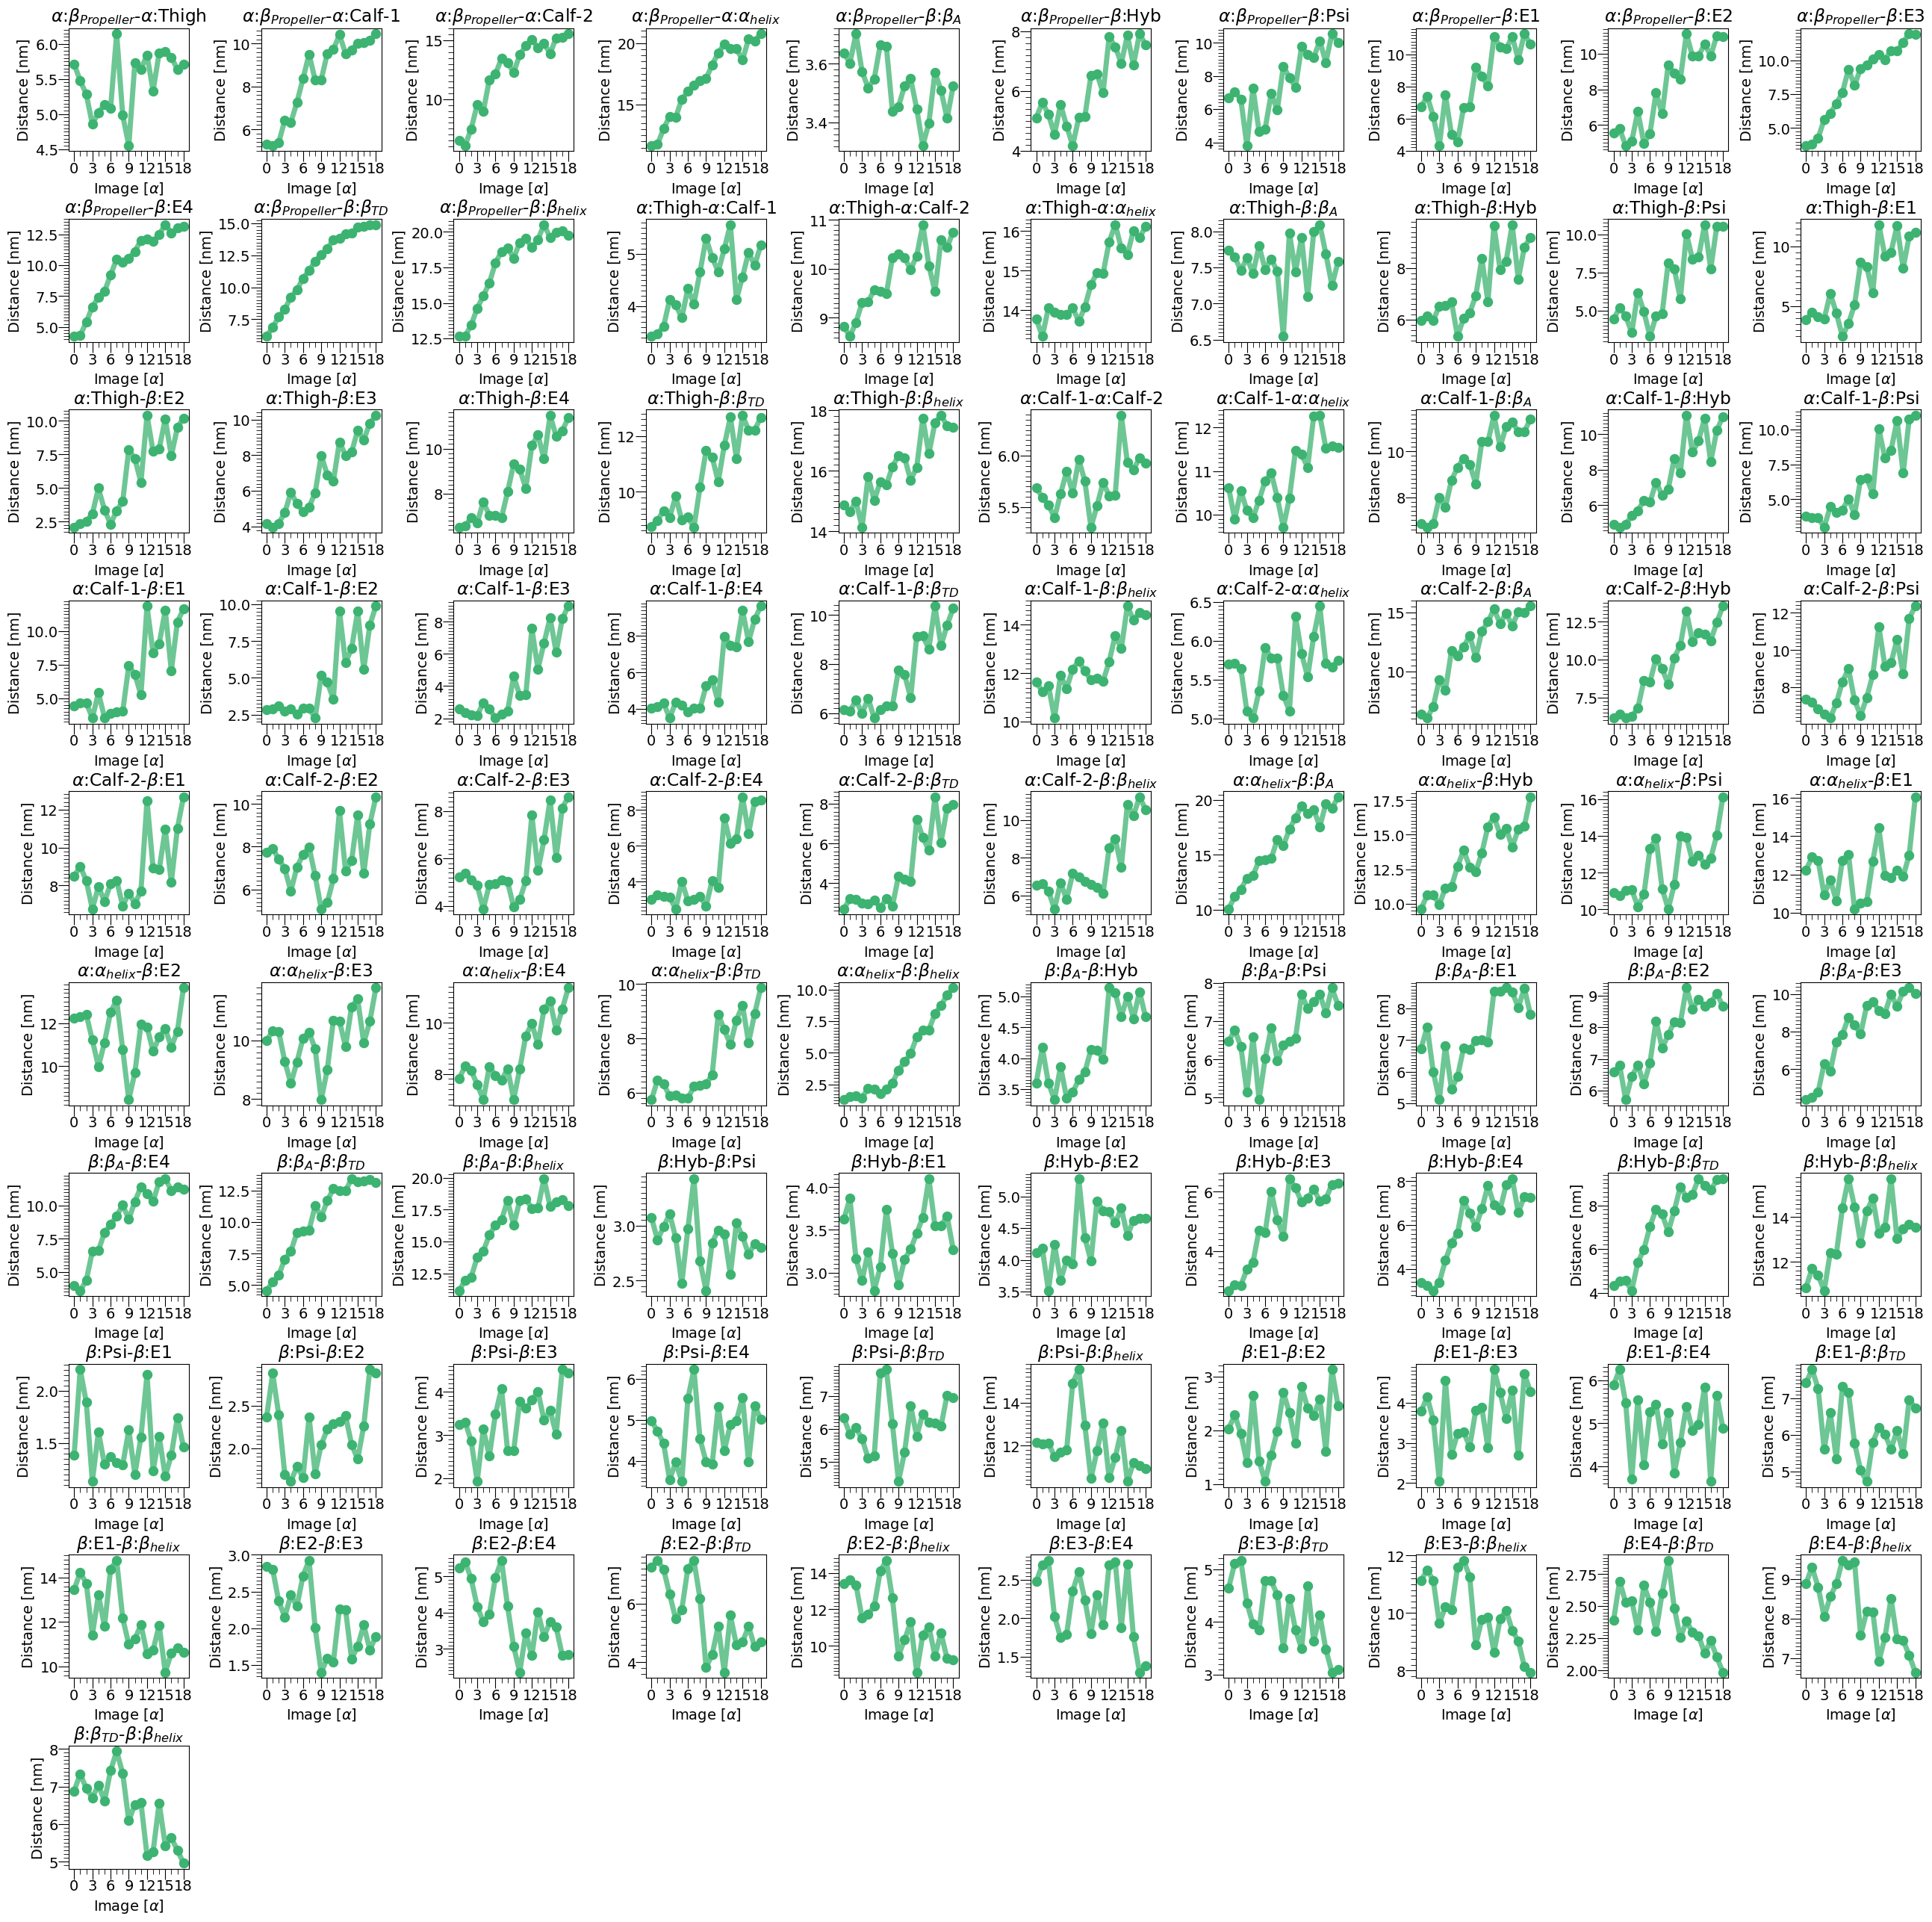

In [41]:
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator, MultipleLocator, AutoMinorLocator

font = {'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

fig = plt.figure(figsize=(32,32))


rows=10
cols=10

count_figs = 0
gs = gridspec.GridSpec(rows, cols, hspace=0.55, wspace=0.6)


for i in range(len(plot_xvals)):
    
    
    ax = fig.add_subplot(gs[count_figs])
    
    ax.plot(np.arange(len(plot_yvals[plot_xvals[i]])), plot_yvals[plot_xvals[i]], c='mediumseagreen',
           lw=5, alpha=0.75)
    ax.scatter(np.arange(len(plot_yvals[plot_xvals[i]])), plot_yvals[plot_xvals[i]], c='mediumseagreen',
           s=75, alpha=1)  
#     ticks=list(np.arange(len(plot_xvals)))

#     ax.set_xticks(ticks=ticks)
    #ax.set_xticklabels(labels=plot_xlabels, rotation=0, ha='right', fontsize=12)

    ax.set_title(plot_xlabels[i])
    ax.set_ylabel('Distance [nm]')
    ax.set_xlabel(r'Image [$\alpha$]')
    

# ax.set_ylim(-3,6*np.shape(single_r2_x_values)[0]-1)
# ax.set_xlim(0,0.4)

    ax.xaxis.set_major_locator(MultipleLocator(3))
    ax.xaxis.set_minor_locator(AutoMinorLocator(n=3))
#     ax.yaxis.set_major_locator(MultipleLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
    
    ax.tick_params(axis='y', which='major', length=10, pad=0)
    ax.tick_params(axis='x', which='major', length=10, pad=0)
    ax.tick_params(axis='y', which='minor', length=5)
    ax.tick_params(axis='x', which='minor', length=5)
    
    count_figs += 1



## Only between alpha and beta subunits

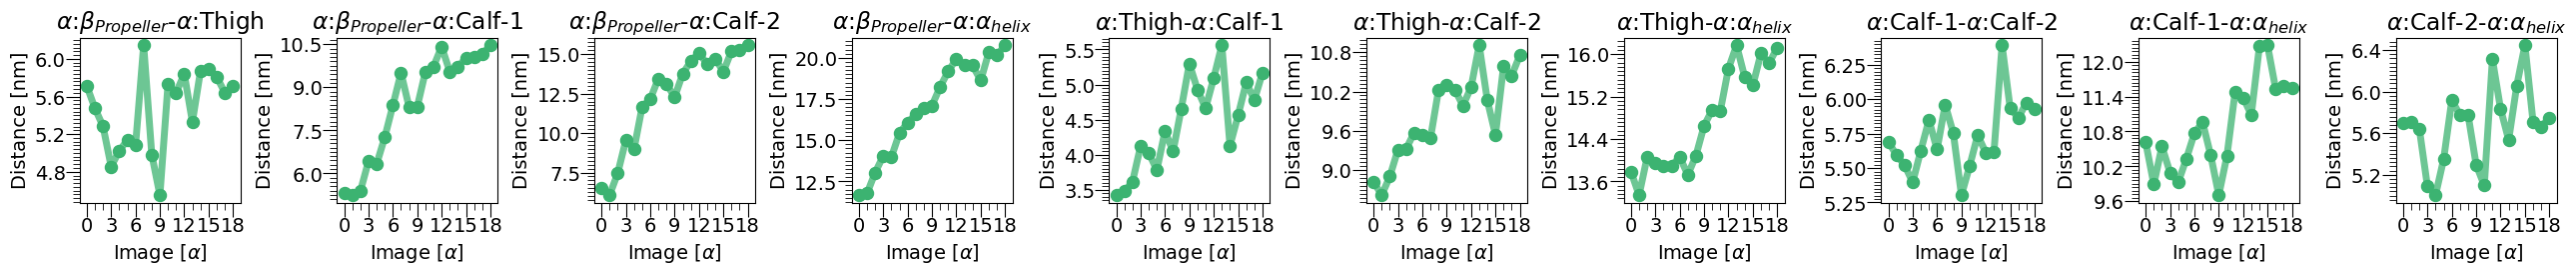

In [42]:
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator, MultipleLocator, AutoMinorLocator

font = {'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

fig = plt.figure(figsize=(32,32))


rows=10
cols=10

count_figs = 0
gs = gridspec.GridSpec(rows, cols, hspace=0.55, wspace=0.6)


for i in range(len(plot_xvals)):
    
    if plot_subunit[i] != 1:
#     if plot_subunit[i] != 0: 
#     if plot_subunit[i] != 2:
        
        continue
    
    
    ax = fig.add_subplot(gs[count_figs])
    
    ax.plot(np.arange(len(plot_yvals[plot_xvals[i]])), plot_yvals[plot_xvals[i]], c='mediumseagreen',
           lw=5, alpha=0.75)
    ax.scatter(np.arange(len(plot_yvals[plot_xvals[i]])), plot_yvals[plot_xvals[i]], c='mediumseagreen',
           s=75, alpha=1)  
#     ticks=list(np.arange(len(plot_xvals)))

#     ax.set_xticks(ticks=ticks)
    #ax.set_xticklabels(labels=plot_xlabels, rotation=0, ha='right', fontsize=12)

    ax.set_title(plot_xlabels[i])
    ax.set_ylabel('Distance [nm]')
    ax.set_xlabel(r'Image [$\alpha$]')
    

# ax.set_ylim(-3,6*np.shape(single_r2_x_values)[0]-1)
# ax.set_xlim(0,0.4)

    ax.xaxis.set_major_locator(MultipleLocator(3))
    ax.xaxis.set_minor_locator(AutoMinorLocator(n=3))
#     ax.yaxis.set_major_locator(MultipleLocator(2))
    ax.yaxis.set_major_locator(MaxNLocator(5))
    
    ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
    
    ax.tick_params(axis='y', which='major', length=10, pad=0)
    ax.tick_params(axis='x', which='major', length=10, pad=0)
    ax.tick_params(axis='y', which='minor', length=5)
    ax.tick_params(axis='x', which='minor', length=5)
    
    count_figs += 1



## group them

In [43]:
plot_yvals

{'beta_propeller_com-thigh_com': [5.7124354841993945,
  5.475618197856667,
  5.283207297985933,
  4.855240372537086,
  5.022911786506066,
  5.136534501136572,
  5.080390210670732,
  6.145535047098706,
  4.982874784432867,
  4.551985001234391,
  5.732809670779896,
  5.640082194943141,
  5.840260979399451,
  5.329936843320555,
  5.87406696823028,
  5.895970108235911,
  5.808723720977199,
  5.638852773889139,
  5.711181185339522],
 'beta_propeller_com-calf_1_com': [5.326856911188033,
  5.244546334661139,
  5.38500044040944,
  6.42684563963145,
  6.323074572251694,
  7.26128716711861,
  8.371851279339698,
  9.507738692067496,
  8.303125841639254,
  8.321898905016392,
  9.538632130273465,
  9.721711373738298,
  10.419966690708476,
  9.544143023594469,
  9.715589125991407,
  10.019609867770603,
  10.052317317488015,
  10.157580486057004,
  10.466670948725564],
 'beta_propeller_com-calf_2_com': [6.496602803000582,
  6.0697601949322495,
  7.46544755904373,
  9.55737445317671,
  8.9725110833032

In [44]:
plot_domain_group = []
plot_xvals_group = []
plot_subunit_group = []
plot_xlabels_group = []
for i in range(len(plot_subunit)):
    
    if plot_subunit[i] == 1:
        plot_domain_group.append(plot_domain[i])
        plot_xvals_group.append(plot_xvals[i])
        plot_subunit_group.append(plot_subunit[i])
        plot_xlabels_group.append(plot_xlabels[i])

# plot_domain_group,plot_xvals_group,plot_subunit_group,plot_xlabels_group

4


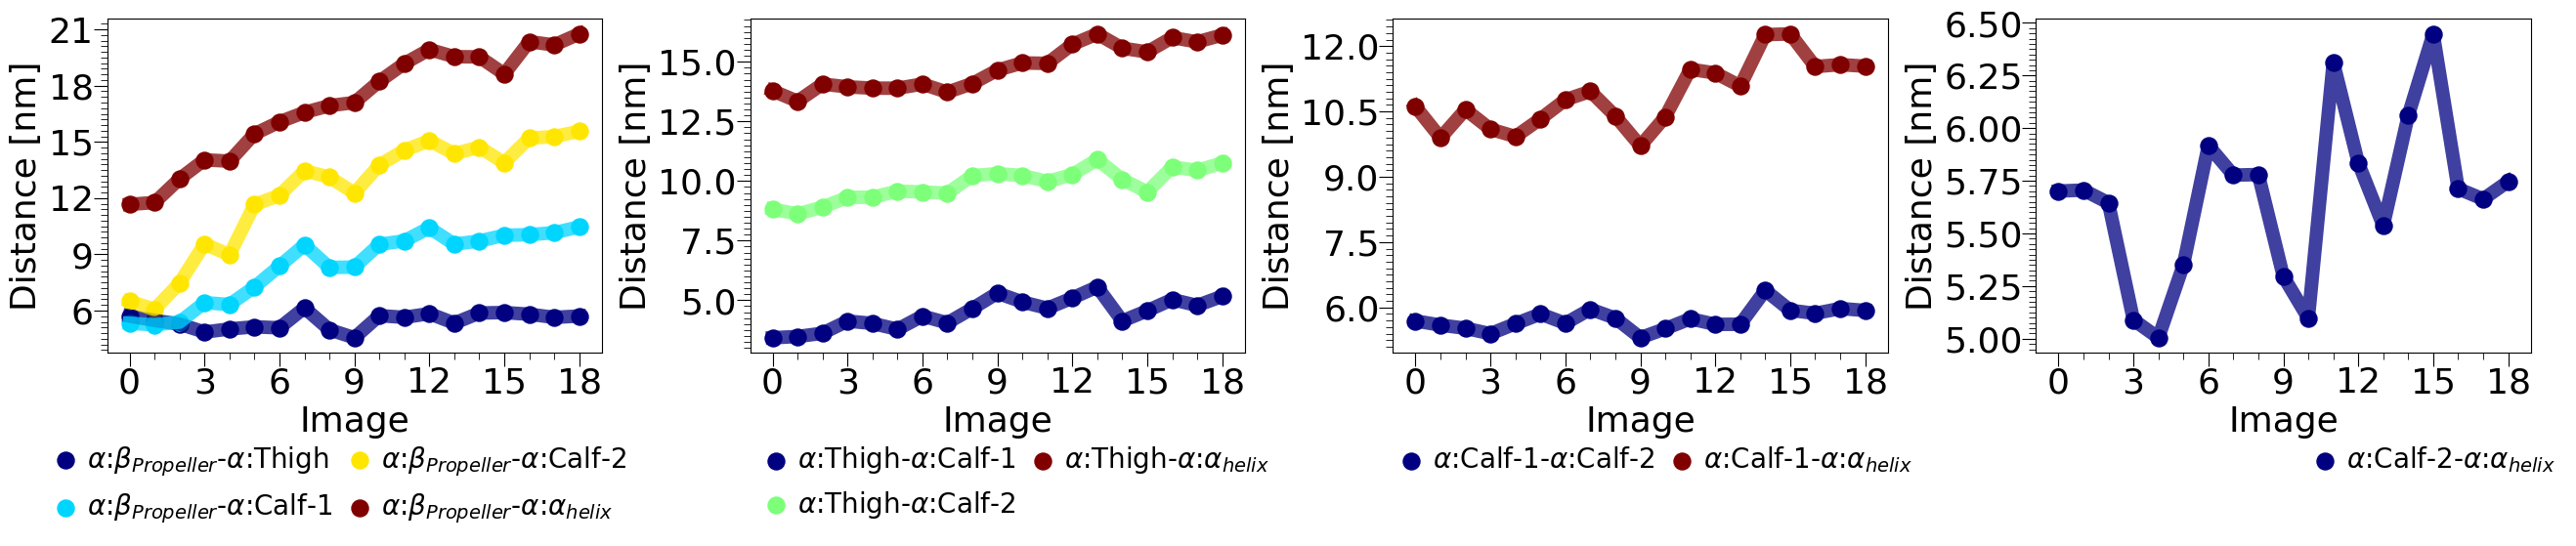

In [45]:
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator, MultipleLocator, AutoMinorLocator
from collections import Counter

font = {'weight' : 'normal',
        'size'   : 26}

plt.rc('font', **font)

fig = plt.figure(figsize=(32,12))


rows=2
cols=4

count_figs = 0
gs = gridspec.GridSpec(rows, cols, hspace=0.7, wspace=0.3)



# Choose a colormap
cmap = plt.get_cmap('jet')

old_domain = plot_domain_group[0]

ncolors = Counter([x == old_domain for x in plot_domain_group])[True]
values = np.linspace(0, 1, ncolors)
print(ncolors)
colors = cmap(values)



ax = fig.add_subplot(gs[0])
color_index = 0
count_index = 1
for i in range(len(plot_xvals_group)):

    
    if plot_domain_group[i] != old_domain:
        ax = fig.add_subplot(gs[count_index])
        old_domain = plot_domain_group[i]
        color_index = 0
        count_index+=1

        ncolors = Counter([x == old_domain for x in plot_domain_group])[True]
        values = np.linspace(0, 1, ncolors)
        colors = cmap(values)
        
    
    ax.plot(np.arange(len(plot_yvals[plot_xvals_group[i]])), plot_yvals[plot_xvals_group[i]],
           lw=10, alpha=0.75, color=colors[color_index])
    ax.scatter(np.arange(len(plot_yvals[plot_xvals_group[i]])), plot_yvals[plot_xvals_group[i]],
           s=150, alpha=1, label=plot_xlabels_group[i], color=colors[color_index])  
#     ticks=list(np.arange(len(plot_xvals)))

#     ax.set_xticks(ticks=ticks)
    #ax.set_xticklabels(labels=plot_xlabels, rotation=0, ha='right', fontsize=12)

    #ax.set_title(plot_xlabels[i])
    ax.set_ylabel('Distance [nm]')
    ax.set_xlabel(r'Image')# [$\alpha$]')
    
    ax.legend(frameon=False, fontsize=20, handlelength=0, bbox_to_anchor=(1.1, -0.2), ncol=2, columnspacing=1)

# ax.set_ylim(-3,6*np.shape(single_r2_x_values)[0]-1)
# ax.set_xlim(0,0.4)

    ax.xaxis.set_major_locator(MultipleLocator(3))
    ax.xaxis.set_minor_locator(AutoMinorLocator(n=3))
#     ax.yaxis.set_major_locator(MultipleLocator(2))
    ax.yaxis.set_major_locator(MaxNLocator(7))
    
    ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
    
    ax.tick_params(axis='y', which='major', length=10, pad=0)
    ax.tick_params(axis='x', which='major', length=10, pad=0)
    ax.tick_params(axis='y', which='minor', length=5)
    ax.tick_params(axis='x', which='minor', length=5)
    
    color_index+=1
    
    

In [46]:
plot_domain_group = []
plot_xvals_group = []
plot_subunit_group = []
plot_xlabels_group = []
for i in range(len(plot_subunit)):
    
    if plot_subunit[i] == 0:
        plot_domain_group.append(plot_domain[i])
        plot_xvals_group.append(plot_xvals[i])
        plot_subunit_group.append(plot_subunit[i])
        plot_xlabels_group.append(plot_xlabels[i])

#plot_domain_group#,plot_xvals_group,plot_subunit_group,plot_xlabels_group

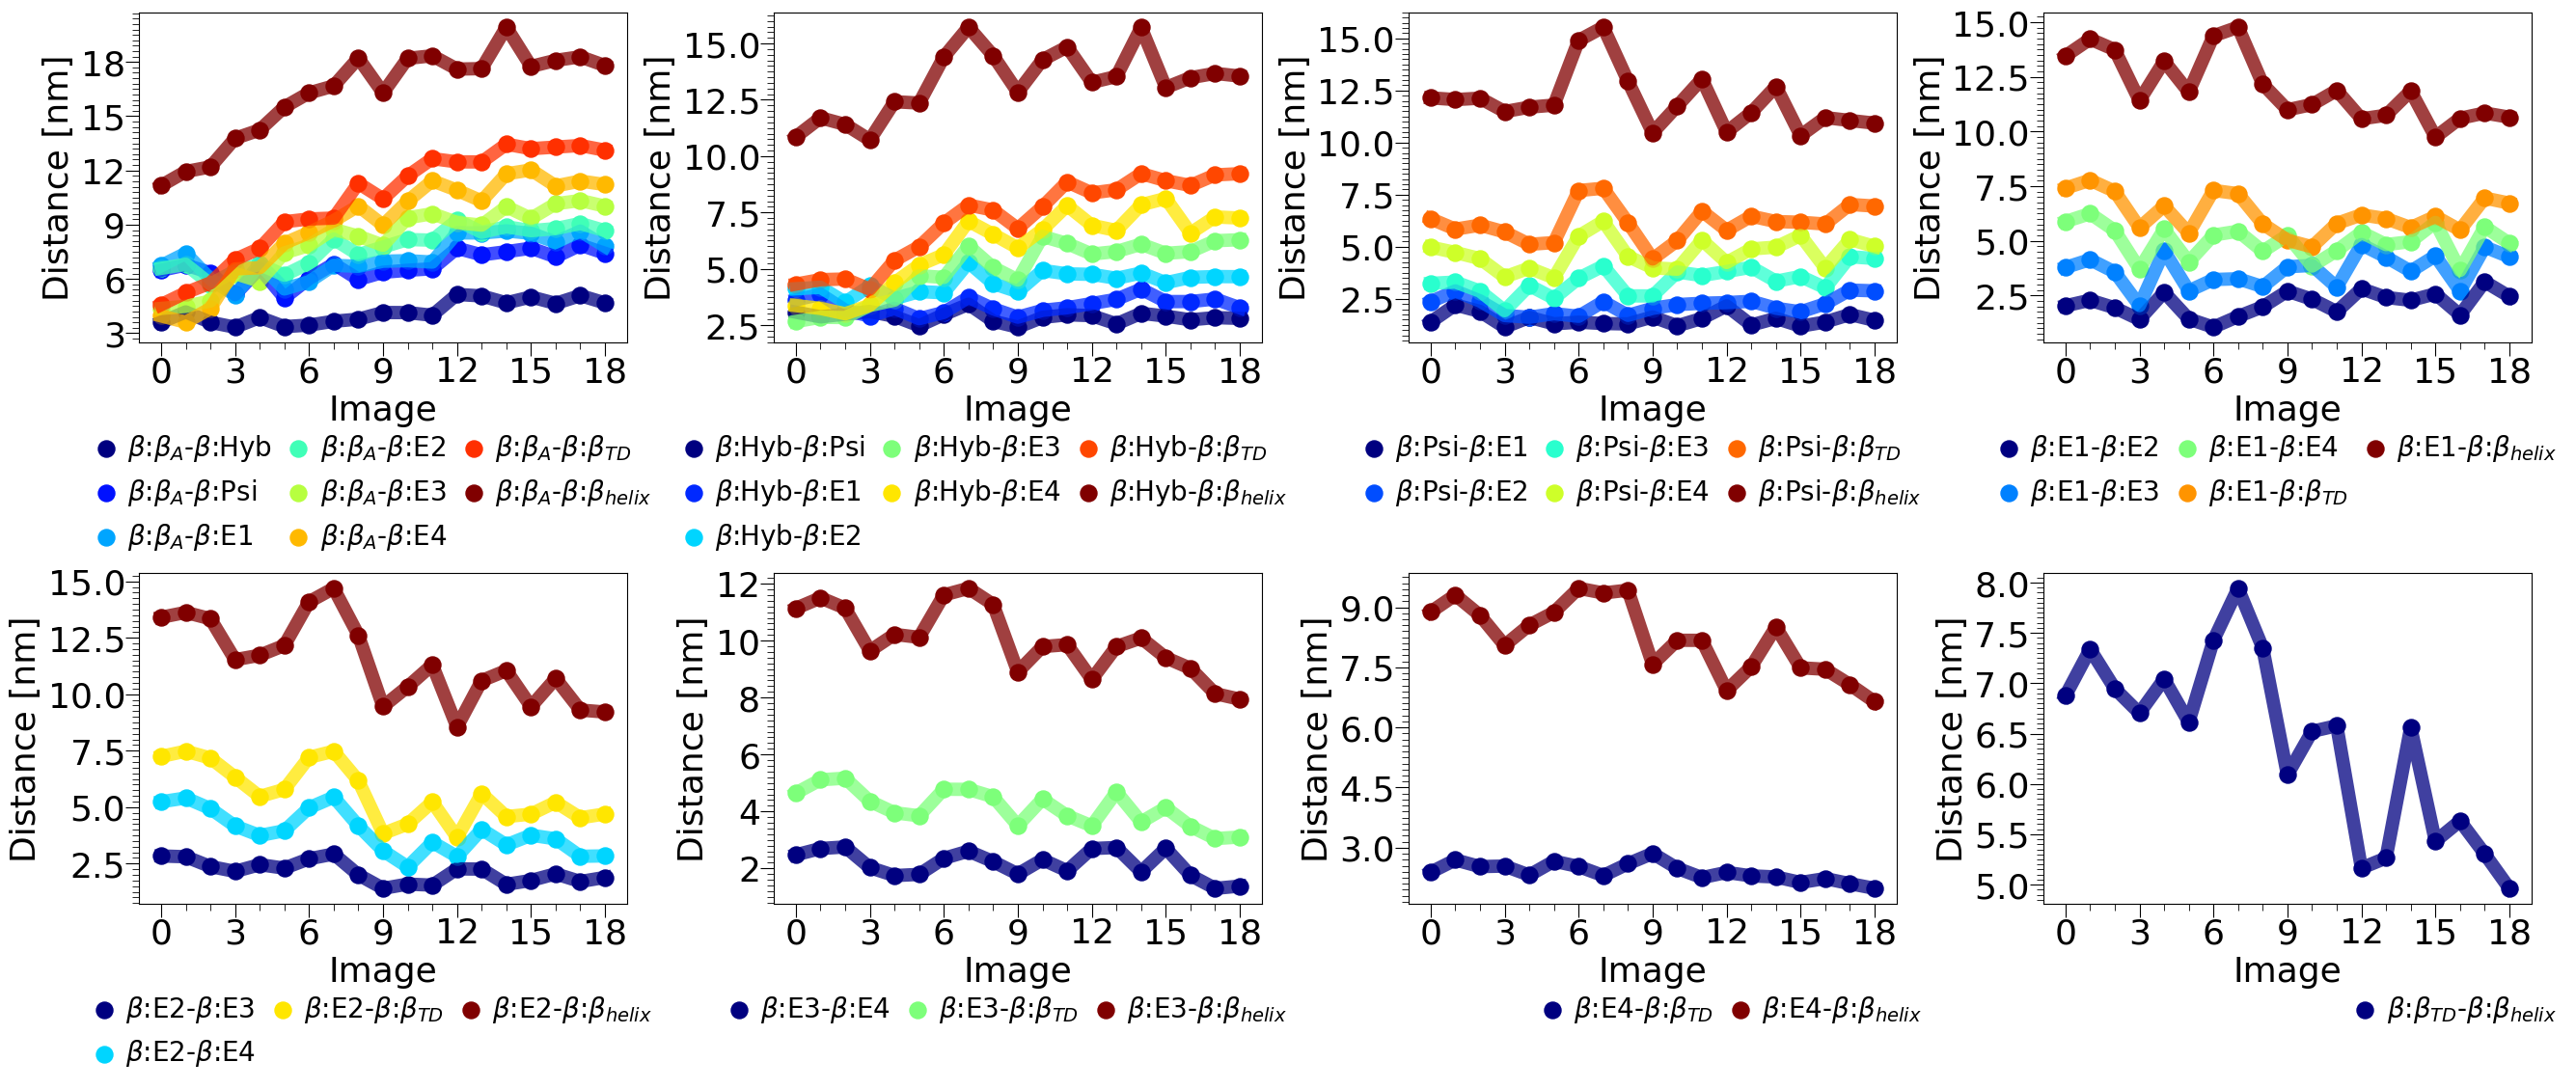

In [47]:
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator, MultipleLocator, AutoMinorLocator

font = {'weight' : 'normal',
        'size'   : 26}

plt.rc('font', **font)

fig = plt.figure(figsize=(32,12))


rows=2
cols=4

count_figs = 0
gs = gridspec.GridSpec(rows, cols, hspace=0.7, wspace=0.3)



# Choose a colormap
cmap = plt.get_cmap('jet')

old_domain = plot_domain_group[0]

ncolors = Counter([x == old_domain for x in plot_domain_group])[True]
values = np.linspace(0, 1, ncolors)
#print(ncolors)
colors = cmap(values)


ax = fig.add_subplot(gs[0])
color_index = 0
count_index = 1
for i in range(len(plot_xvals_group)):

    
    if plot_domain_group[i] != old_domain:
        ax = fig.add_subplot(gs[count_index])
        old_domain = plot_domain_group[i]
        color_index = 0
        count_index+=1

        ncolors = Counter([x == old_domain for x in plot_domain_group])[True]
        values = np.linspace(0, 1, ncolors)
        colors = cmap(values)
        
    
    ax.plot(np.arange(len(plot_yvals[plot_xvals_group[i]])), plot_yvals[plot_xvals_group[i]],
           lw=10, alpha=0.75, color=colors[color_index])
    ax.scatter(np.arange(len(plot_yvals[plot_xvals_group[i]])), plot_yvals[plot_xvals_group[i]],
           s=150, alpha=1, label=plot_xlabels_group[i], color=colors[color_index])  
#     ticks=list(np.arange(len(plot_xvals)))

#     ax.set_xticks(ticks=ticks)
    #ax.set_xticklabels(labels=plot_xlabels, rotation=0, ha='right', fontsize=12)

    #ax.set_title(plot_xlabels[i])
    ax.set_ylabel('Distance [nm]')
    ax.set_xlabel(r'Image')# [$\alpha$]')
    
    ax.legend(frameon=False, fontsize=20, handlelength=0, bbox_to_anchor=(1.1, -0.2), ncol=3, columnspacing=1)

# ax.set_ylim(-3,6*np.shape(single_r2_x_values)[0]-1)
# ax.set_xlim(0,0.4)

    ax.xaxis.set_major_locator(MultipleLocator(3))
    ax.xaxis.set_minor_locator(AutoMinorLocator(n=3))
#     ax.yaxis.set_major_locator(MultipleLocator(2))
    ax.yaxis.set_major_locator(MaxNLocator(7))
    
    ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
    
    ax.tick_params(axis='y', which='major', length=10, pad=0)
    ax.tick_params(axis='x', which='major', length=10, pad=0)
    ax.tick_params(axis='y', which='minor', length=5)
    ax.tick_params(axis='x', which='minor', length=5)
    
    color_index+=1
    
    

In [48]:
plot_domain_group = []
plot_xvals_group = []
plot_subunit_group = []
plot_xlabels_group = []
for i in range(len(plot_subunit)):
    
    if plot_subunit[i] == 2:
        plot_domain_group.append(plot_domain[i])
        plot_xvals_group.append(plot_xvals[i])
        plot_subunit_group.append(plot_subunit[i])
        plot_xlabels_group.append(plot_xlabels[i])

#plot_domain_group#,plot_xvals_group,plot_subunit_group,plot_xlabels_group

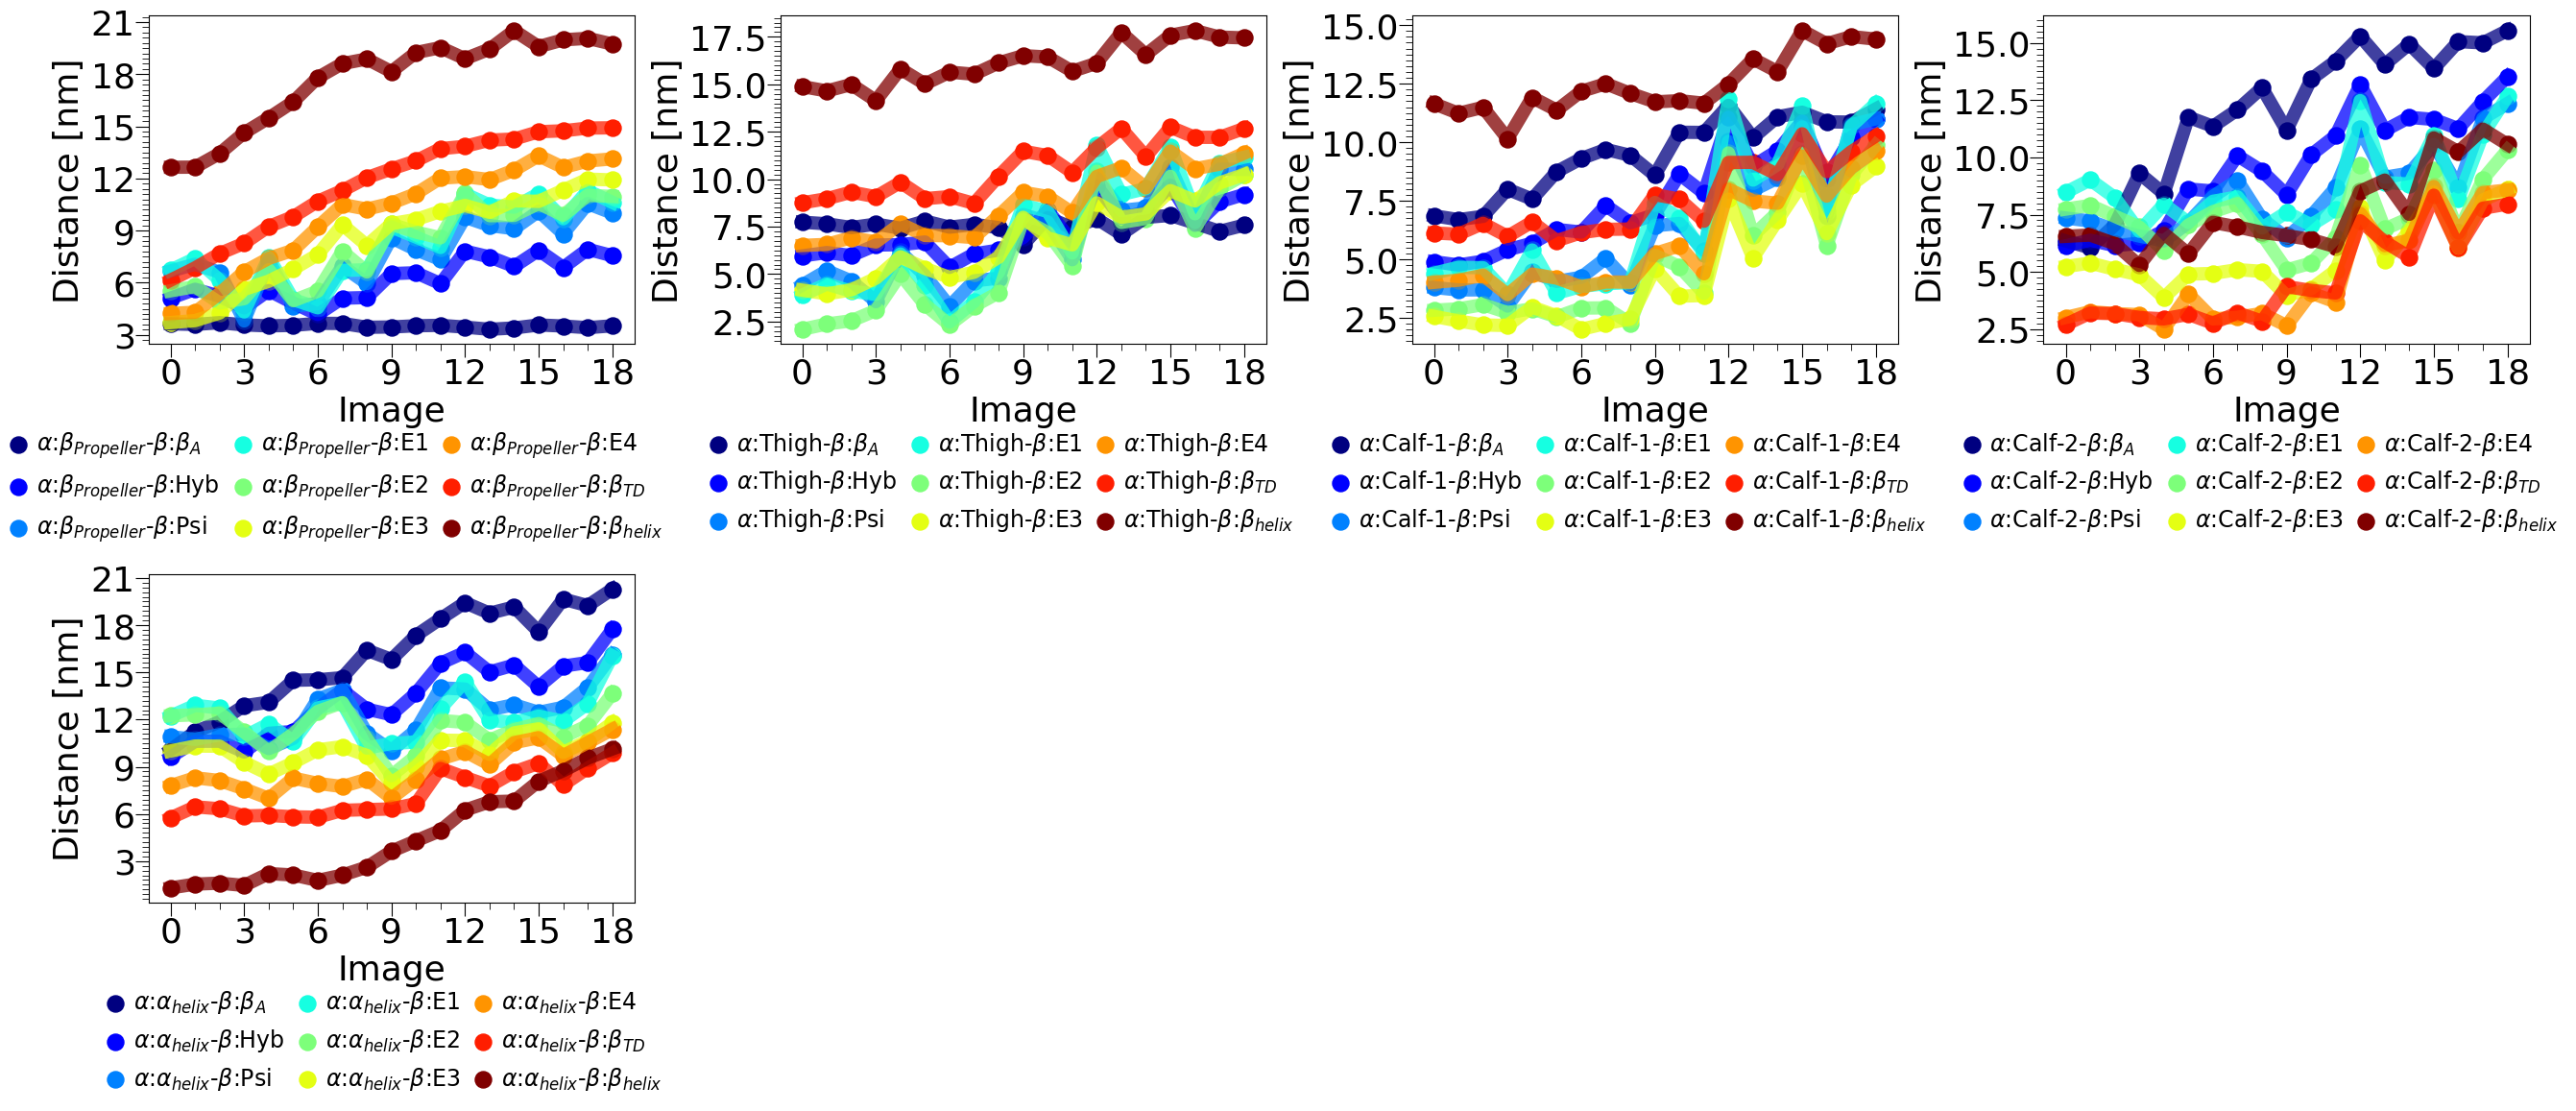

In [49]:
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator, MultipleLocator, AutoMinorLocator

font = {'weight' : 'normal',
        'size'   : 26}

plt.rc('font', **font)


fig = plt.figure(figsize=(32,12))


rows=2
cols=4

count_figs = 0
gs = gridspec.GridSpec(rows, cols, hspace=0.7, wspace=0.3)



# Choose a colormap
cmap = plt.get_cmap('jet')

old_domain = plot_domain_group[0]

ncolors = Counter([x == old_domain for x in plot_domain_group])[True]
values = np.linspace(0, 1, ncolors)
#print(ncolors)
colors = cmap(values)


ax = fig.add_subplot(gs[0])
color_index = 0
count_index = 1
for i in range(len(plot_xvals_group)):

    
    if plot_domain_group[i] != old_domain:
        ax = fig.add_subplot(gs[count_index])
        old_domain = plot_domain_group[i]
        color_index = 0
        count_index+=1

        ncolors = Counter([x == old_domain for x in plot_domain_group])[True]
        values = np.linspace(0, 1, ncolors)
        colors = cmap(values)
        
    
    ax.plot(np.arange(len(plot_yvals[plot_xvals_group[i]])), plot_yvals[plot_xvals_group[i]],
           lw=10, alpha=0.75, color=colors[color_index])
    ax.scatter(np.arange(len(plot_yvals[plot_xvals_group[i]])), plot_yvals[plot_xvals_group[i]],
           s=150, alpha=1, label=plot_xlabels_group[i], color=colors[color_index])  
#     ticks=list(np.arange(len(plot_xvals)))

#     ax.set_xticks(ticks=ticks)
    #ax.set_xticklabels(labels=plot_xlabels, rotation=0, ha='right', fontsize=12)

    #ax.set_title(plot_xlabels[i])
    ax.set_ylabel('Distance [nm]')
    ax.set_xlabel(r'Image')# [$\alpha$]')
    
    ax.legend(frameon=False, fontsize=17, handlelength=0, bbox_to_anchor=(1.1, -0.2), ncol=3, columnspacing=1)

# ax.set_ylim(-3,6*np.shape(single_r2_x_values)[0]-1)
# ax.set_xlim(0,0.4)

    ax.xaxis.set_major_locator(MultipleLocator(3))
    ax.xaxis.set_minor_locator(AutoMinorLocator(n=3))
#     ax.yaxis.set_major_locator(MultipleLocator(2))
    ax.yaxis.set_major_locator(MaxNLocator(7))
    
    ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
    
    ax.tick_params(axis='y', which='major', length=10, pad=0)
    ax.tick_params(axis='x', which='major', length=10, pad=0)
    ax.tick_params(axis='y', which='minor', length=5)
    ax.tick_params(axis='x', which='minor', length=5)
    
    color_index+=1
    
    

## Correlations

In [50]:

from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_squared_error

distance_correlations = {}
for i in range(len(plot_xvals)):
    
    distance_correlations_i = {}
    for j in range(len(plot_xvals)):
        
        if j <= i:
            continue
            
        x, y =  plot_yvals[plot_xvals[i]], plot_yvals[plot_xvals[j]]
        pearson_corr, _ = pearsonr(x, y)
        distance_correlations_i[plot_xvals[j]] = pearson_corr

    distance_correlations[plot_xvals[i]] = distance_correlations_i  
    


In [51]:
# plot_xvals

In [52]:
# i=0
# j=1
# plt.scatter(plot_yvals[plot_xvals[i]], plot_yvals[plot_xvals[j]])

# from scipy.stats import pearsonr

# # Example data
# x = plot_yvals[plot_xvals[i]]
# y = plot_yvals[plot_xvals[j]]

# # Calculate Pearson correlation
# _, pearson_corr = pearsonr(x, y)
# print(f"Pearson correlation (using scipy): {pearson_corr}")



In [53]:
distance_correlations

{'beta_propeller_com-thigh_com': {'beta_propeller_com-calf_1_com': 0.4837970958572001,
  'beta_propeller_com-calf_2_com': 0.3683907937946956,
  'beta_propeller_com-alpha_transmembrane_com': 0.3880715102585198,
  'beta_propeller_com-beta_1_com': 0.06791961140522665,
  'beta_propeller_com-hyb_com': 0.4537774327607077,
  'beta_propeller_com-psi_com': 0.5133795977905126,
  'beta_propeller_com-e1_com': 0.48289352985216666,
  'beta_propeller_com-e2_com': 0.4830541364055826,
  'beta_propeller_com-e3_com': 0.40893615796847654,
  'beta_propeller_com-e4_com': 0.3877131472622983,
  'beta_propeller_com-beta_t_com': 0.36300742796501756,
  'beta_propeller_com-beta_transmembrane_com': 0.3448195692940852,
  'thigh_com-calf_1_com': -0.0005975758141354981,
  'thigh_com-calf_2_com': 0.09806456327535276,
  'thigh_com-alpha_transmembrane_com': 0.3892104276372259,
  'thigh_com-beta_1_com': 0.6367500265025648,
  'thigh_com-hyb_com': 0.46846996693845505,
  'thigh_com-psi_com': 0.39858049669093276,
  'thigh_co

## Subselect pairs with less than X=80% correlation

In [54]:
distance_correlations_filtered = {}

cutoff = 0.8
for outer_key in distance_correlations:
    
    _distance_correlations_filtered = {}
    for inner_key in distance_correlations[outer_key]:
        
        if np.abs(distance_correlations[outer_key][inner_key]) > cutoff:
            
            _distance_correlations_filtered[inner_key] = distance_correlations[outer_key][inner_key]
        
    if len(list(_distance_correlations_filtered.keys())) != 0:
        distance_correlations_filtered[outer_key] = _distance_correlations_filtered
    
    

In [55]:
distance_correlations

{'beta_propeller_com-thigh_com': {'beta_propeller_com-calf_1_com': 0.4837970958572001,
  'beta_propeller_com-calf_2_com': 0.3683907937946956,
  'beta_propeller_com-alpha_transmembrane_com': 0.3880715102585198,
  'beta_propeller_com-beta_1_com': 0.06791961140522665,
  'beta_propeller_com-hyb_com': 0.4537774327607077,
  'beta_propeller_com-psi_com': 0.5133795977905126,
  'beta_propeller_com-e1_com': 0.48289352985216666,
  'beta_propeller_com-e2_com': 0.4830541364055826,
  'beta_propeller_com-e3_com': 0.40893615796847654,
  'beta_propeller_com-e4_com': 0.3877131472622983,
  'beta_propeller_com-beta_t_com': 0.36300742796501756,
  'beta_propeller_com-beta_transmembrane_com': 0.3448195692940852,
  'thigh_com-calf_1_com': -0.0005975758141354981,
  'thigh_com-calf_2_com': 0.09806456327535276,
  'thigh_com-alpha_transmembrane_com': 0.3892104276372259,
  'thigh_com-beta_1_com': 0.6367500265025648,
  'thigh_com-hyb_com': 0.46846996693845505,
  'thigh_com-psi_com': 0.39858049669093276,
  'thigh_co

In [56]:
pair_labels = {}

for i, label in enumerate(plot_yvals):
    
    pair_labels[label] = plot_xlabels[i]

# pair_labels

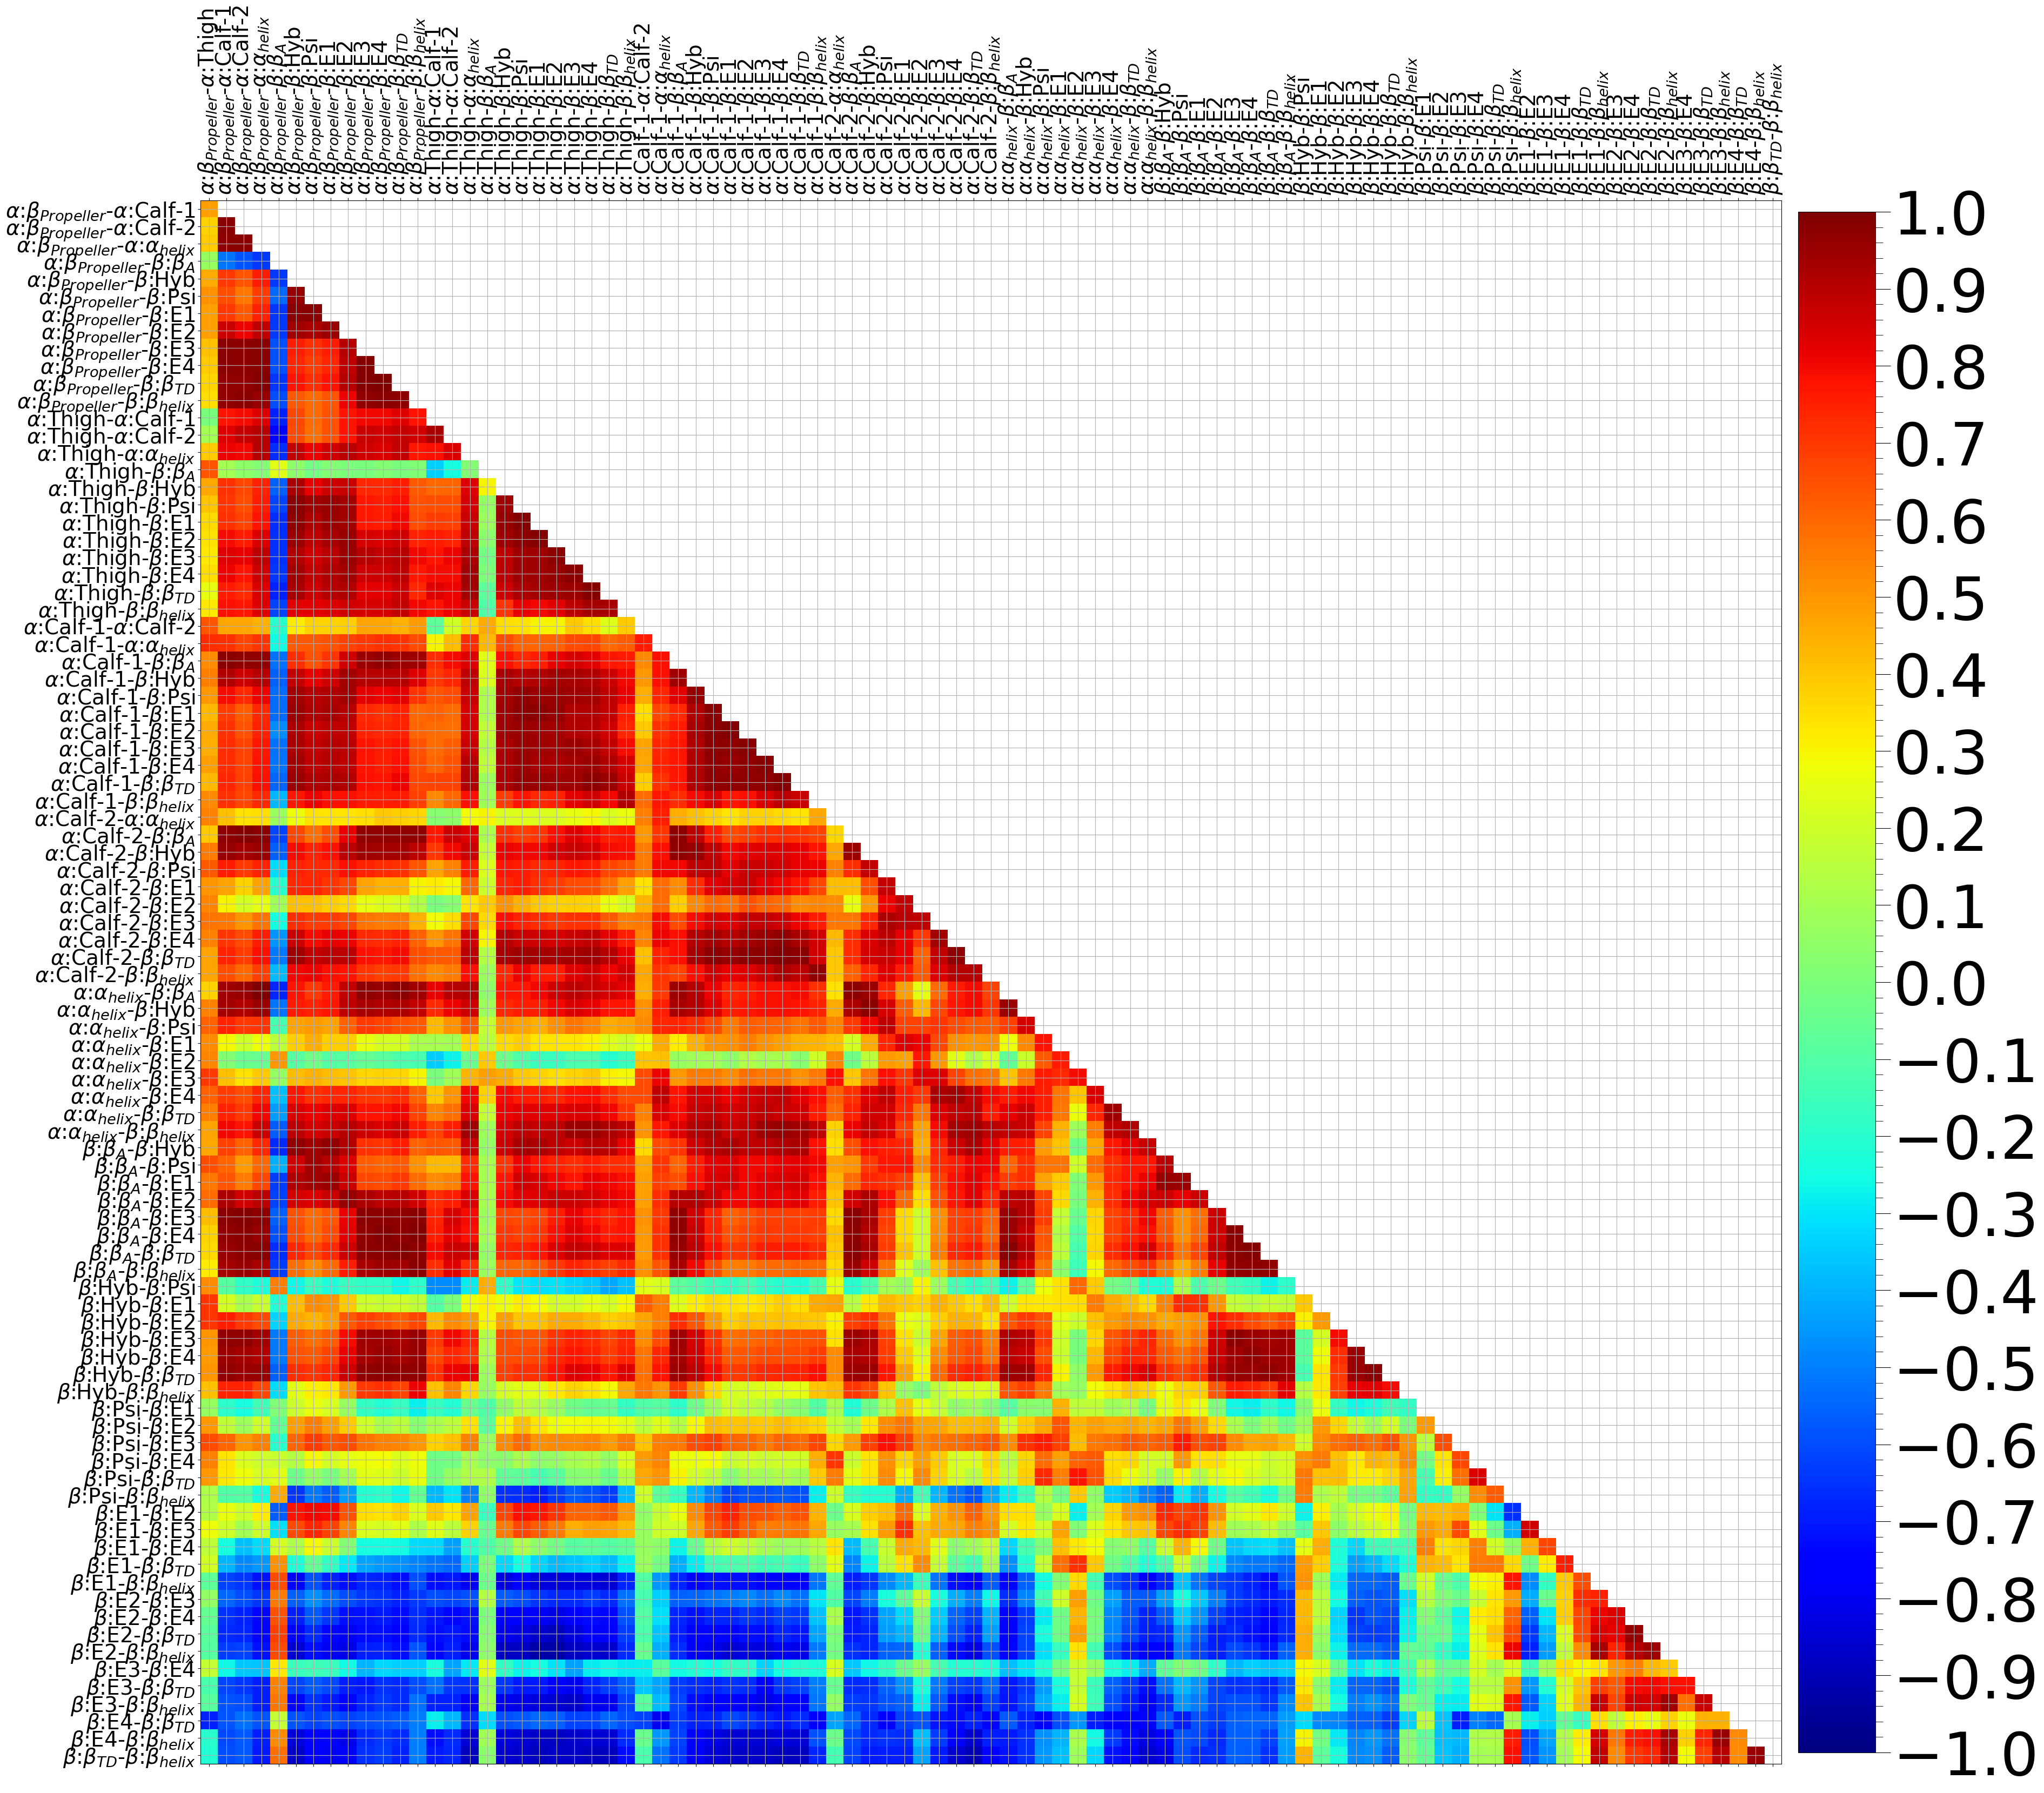

In [57]:
import seaborn as sns
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

font = {'weight' : 'normal',
        'size'   : 24}

plt.rc('font', **font)



corr_df = pd.DataFrame(distance_correlations)
corr_df = corr_df.rename(index=pair_labels, columns=pair_labels)

# Plot the correlation matrix using seaborn
# plt.figure(figsize=(8, 6))
# sns.heatmap(corr_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
fig, ax = plt.subplots(figsize=(40, 40))
cax = ax.matshow(corr_df, cmap='jet', vmin=-1, vmax=1)
# plt.title('Correlation Matrix')
# plt.show()

ax.set_xticks(range(len(corr_df.columns)))
ax.set_yticks(range(len(corr_df.index)))
ax.set_xticklabels(corr_df.columns, fontsize=28, rotation=90)
ax.set_yticklabels(corr_df.index, fontsize=28)

cbar = fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.01)
cbar.ax.tick_params(labelsize=80) 

num_ticks = 21  # Define the number of ticks you want
cbar_ticks = np.linspace(-1, 1, num_ticks)  # Generate ticks
cbar.set_ticks(cbar_ticks)  # Set the ticks

cbar.ax.xaxis.set_minor_locator(AutoMinorLocator(22))  # Set number of minor ticks
# Customize the tick length
cbar.ax.tick_params(which='both', length=20)  # Length of both major and minor ticks
cbar.ax.tick_params(which='minor', length=10)  # Length of minor ticks

cbar.ax.minorticks_on()

# Annotate each cell with the correlation value
# for (i, j), val in np.ndenumerate(corr_df):
#     ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

# plt.title('Correlation Matrix')
# plt.show()
ax.grid()



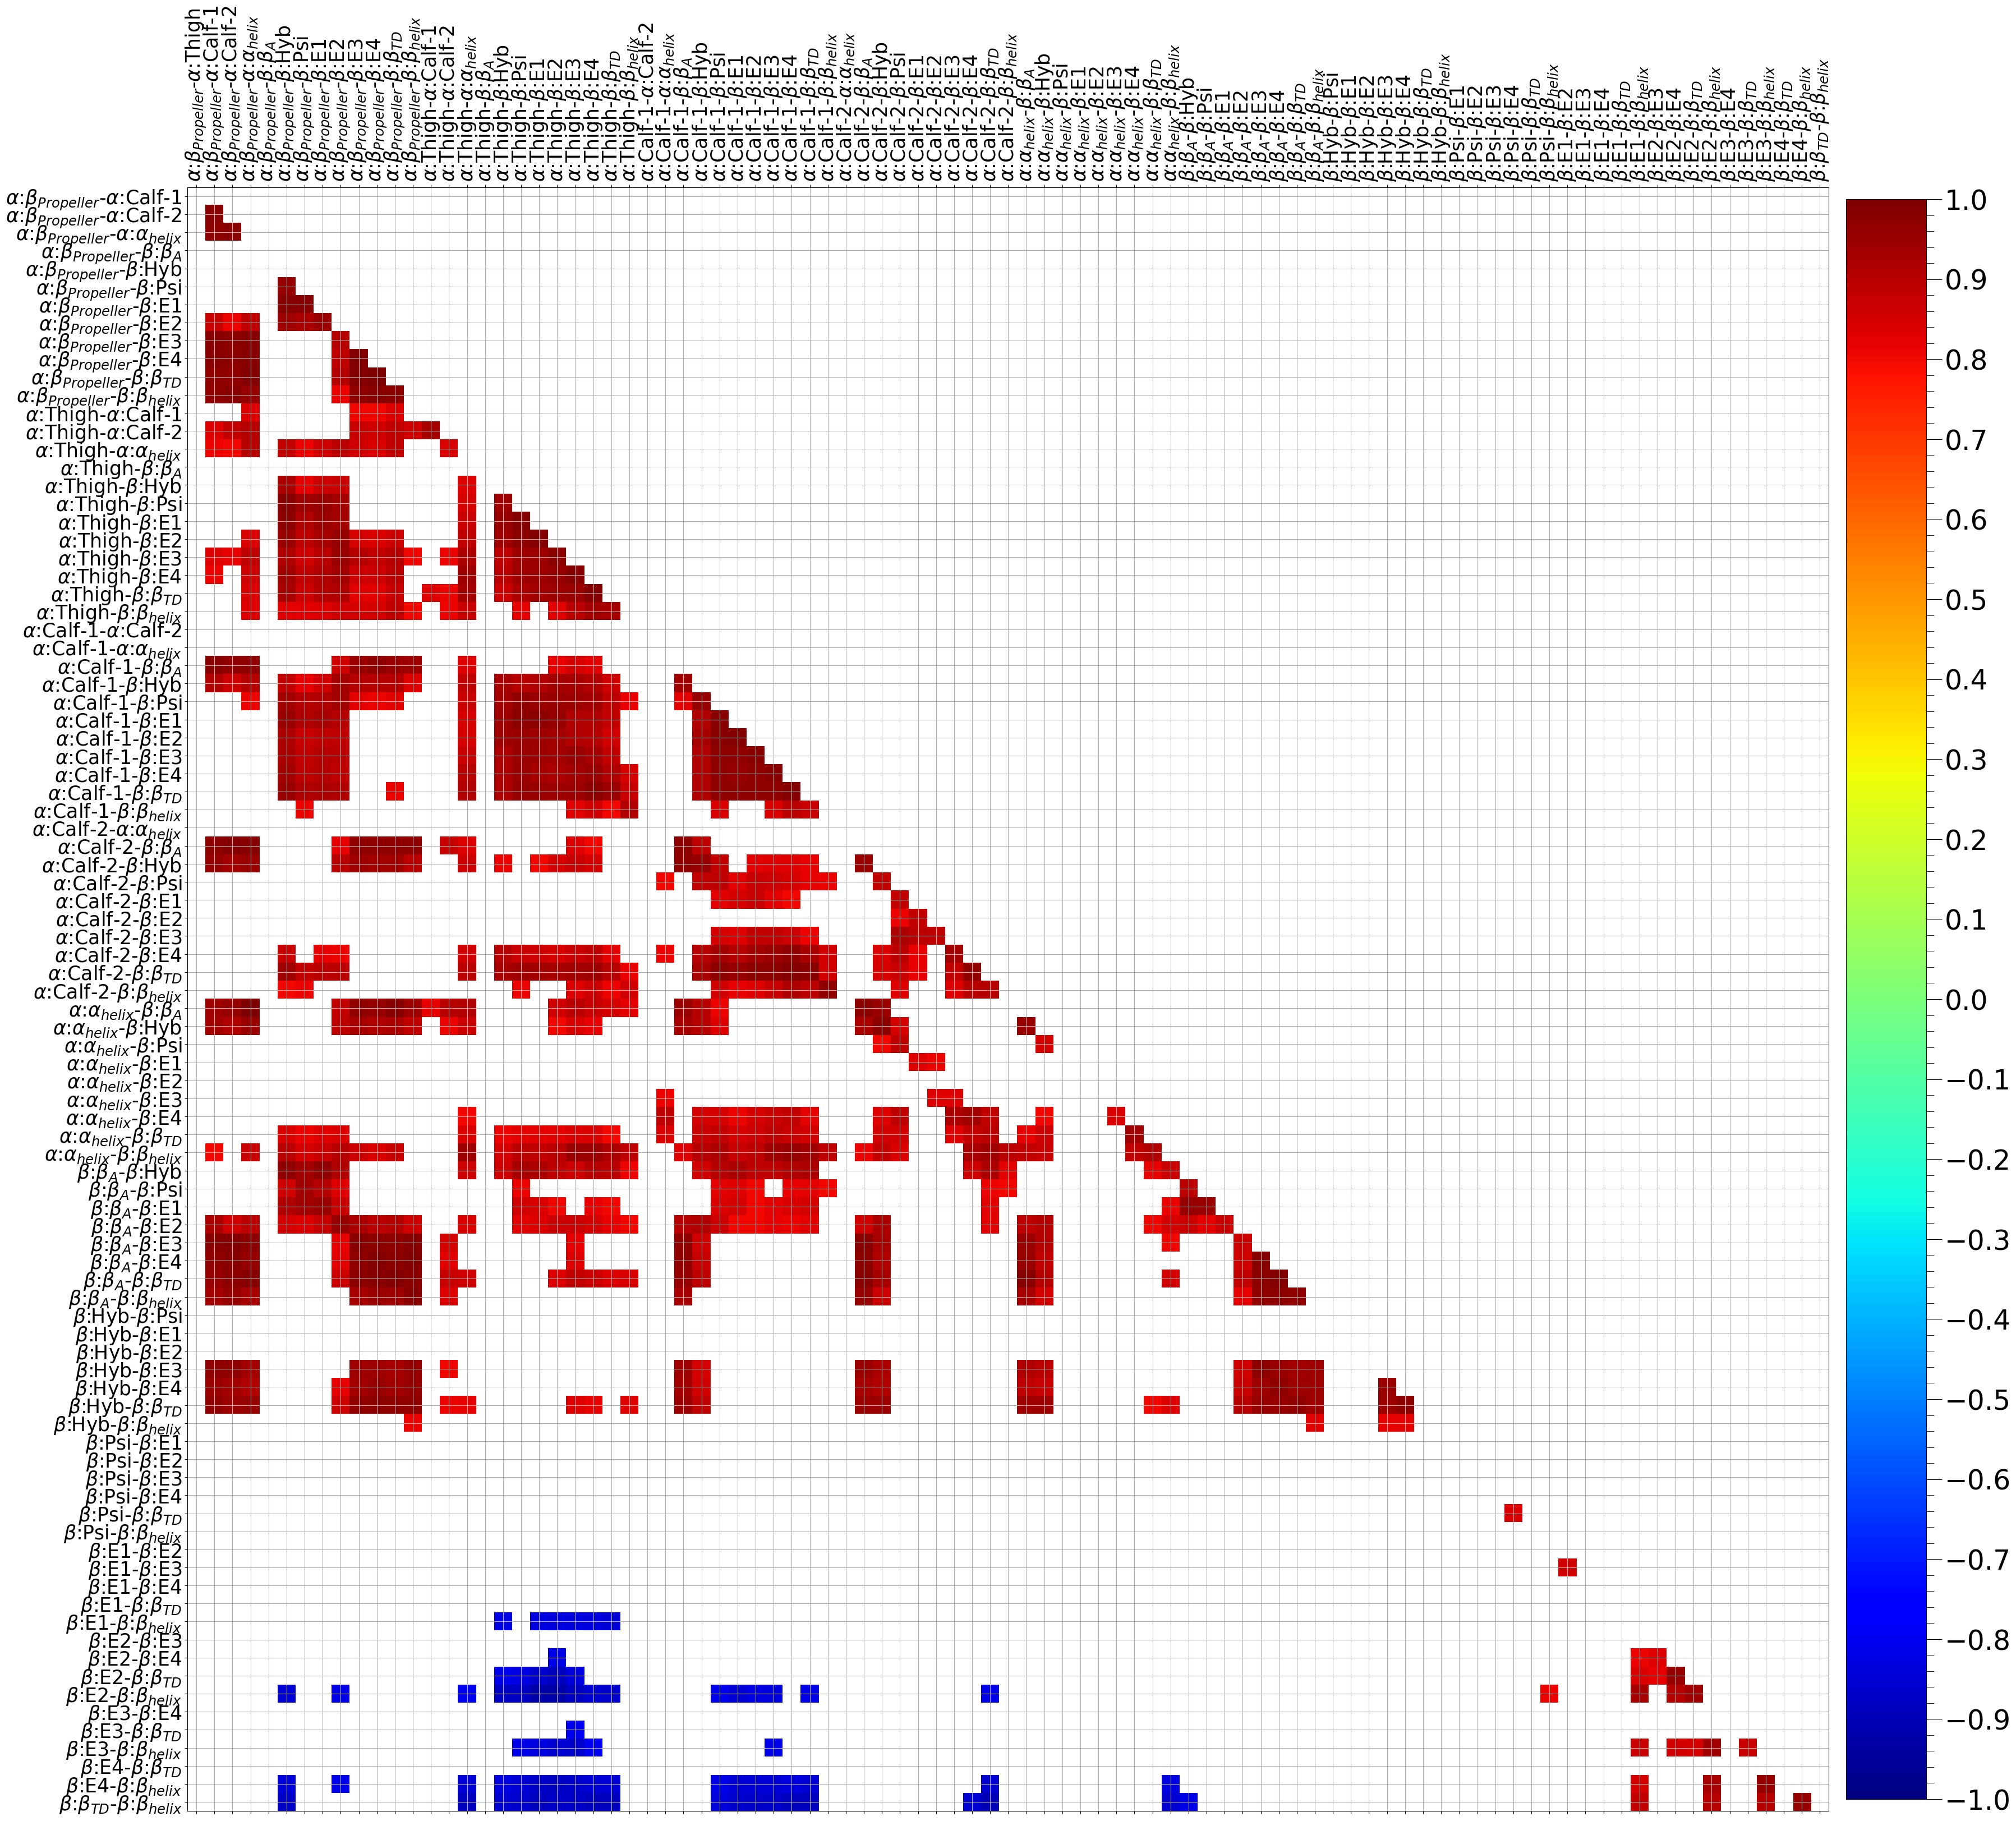

In [58]:
import seaborn as sns
from matplotlib.ticker import MultipleLocator, AutoMinorLocator





corr_df = pd.DataFrame(distance_correlations)
corr_df = corr_df.rename(index=pair_labels, columns=pair_labels)

# Set the absolute cutoff value for correlations
absolute_cutoff = 0.8
# Apply the cutoff to the correlation matrix
corr_df_filtered = corr_df.where(corr_df.abs() > absolute_cutoff, other=np.nan)

# Plot the correlation matrix using seaborn
# plt.figure(figsize=(8, 6))
# sns.heatmap(corr_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
fig, ax = plt.subplots(figsize=(40, 40))
cax = ax.matshow(corr_df_filtered, cmap='jet', vmin=-1, vmax=1)
# plt.title('Correlation Matrix')
# plt.show()

ax.set_xticks(range(len(corr_df_filtered.columns)))
ax.set_yticks(range(len(corr_df_filtered.index)))
ax.set_xticklabels(corr_df_filtered.columns, fontsize=25, rotation=90)
ax.set_yticklabels(corr_df_filtered.index, fontsize=25)

cbar = fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.01)
cbar.ax.tick_params(labelsize=35) 

num_ticks = 21  # Define the number of ticks you want
cbar_ticks = np.linspace(-1, 1, num_ticks)  # Generate ticks
cbar.set_ticks(cbar_ticks)  # Set the ticks

cbar.ax.xaxis.set_minor_locator(AutoMinorLocator(22))  # Set number of minor ticks
# Customize the tick length
cbar.ax.tick_params(which='both', length=20)  # Length of both major and minor ticks
cbar.ax.tick_params(which='minor', length=10)  # Length of minor ticks

cbar.ax.minorticks_on()

ax.grid()

# Annotate each cell with the correlation value
# for (i, j), val in np.ndenumerate(corr_df):
#     ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

# plt.title('Correlation Matrix')
# plt.show()



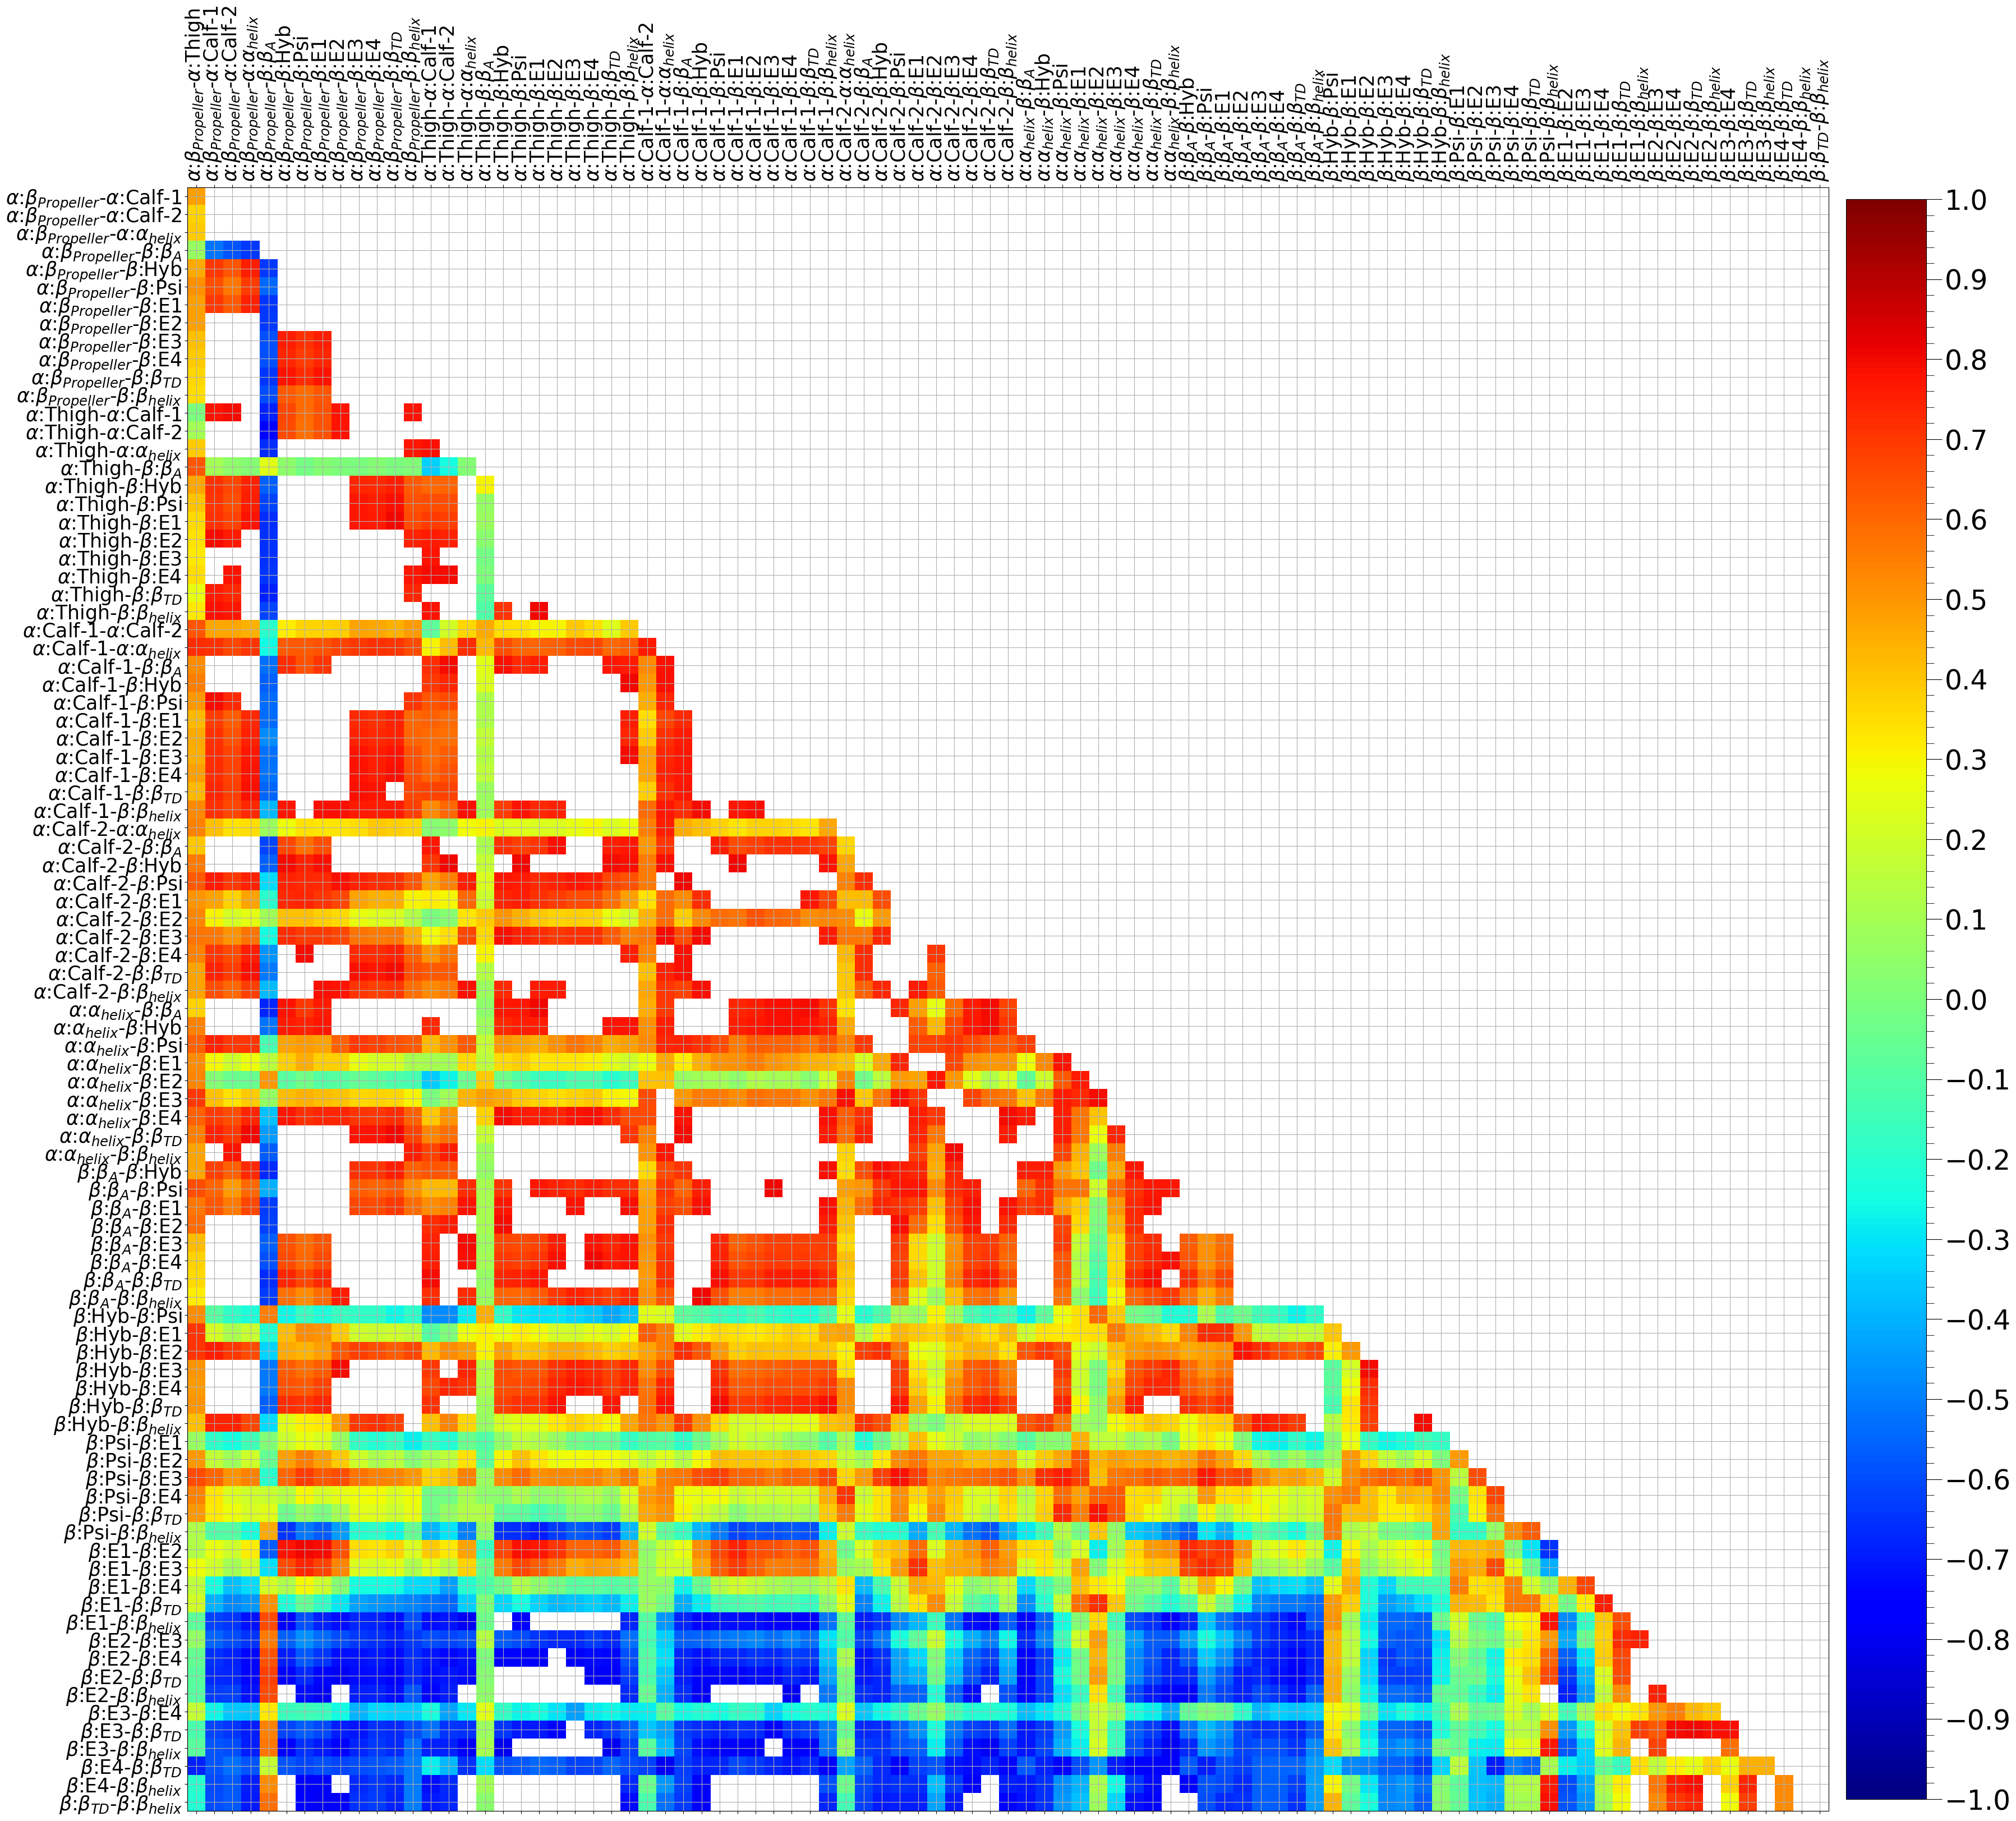

In [59]:
import seaborn as sns
from matplotlib.ticker import MultipleLocator, AutoMinorLocator





corr_df = pd.DataFrame(distance_correlations)
corr_df = corr_df.rename(index=pair_labels, columns=pair_labels)

# Set the absolute cutoff value for correlations
absolute_cutoff = 0.8
# Apply the cutoff to the correlation matrix
corr_df_filtered = corr_df.where(corr_df.abs() < absolute_cutoff, other=np.nan)

# Plot the correlation matrix using seaborn
# plt.figure(figsize=(8, 6))
# sns.heatmap(corr_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
fig, ax = plt.subplots(figsize=(40, 40))
cax = ax.matshow(corr_df_filtered, cmap='jet', vmin=-1, vmax=1)
# plt.title('Correlation Matrix')
# plt.show()

ax.set_xticks(range(len(corr_df_filtered.columns)))
ax.set_yticks(range(len(corr_df_filtered.index)))
ax.set_xticklabels(corr_df_filtered.columns, fontsize=25, rotation=90)
ax.set_yticklabels(corr_df_filtered.index, fontsize=25)

cbar = fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.01)
cbar.ax.tick_params(labelsize=35) 

num_ticks = 21  # Define the number of ticks you want
cbar_ticks = np.linspace(-1, 1, num_ticks)  # Generate ticks
cbar.set_ticks(cbar_ticks)  # Set the ticks

cbar.ax.xaxis.set_minor_locator(AutoMinorLocator(22))  # Set number of minor ticks
# Customize the tick length
cbar.ax.tick_params(which='both', length=20)  # Length of both major and minor ticks
cbar.ax.tick_params(which='minor', length=10)  # Length of minor ticks

cbar.ax.minorticks_on()

# Annotate each cell with the correlation value
# for (i, j), val in np.ndenumerate(corr_df):
#     ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

# plt.title('Correlation Matrix')
# plt.show()
ax.grid()



## Plot only correlated pairs with target 2 CVs in the same plot

In [60]:
cutoff = 0.95

collect_interesting_keys = {}

for target in ['alpha_transmembrane_com-beta_transmembrane_com', 'beta_propeller_com-beta_t_com']:

    list_keys = []
    for outer_key in distance_correlations:

        for inner_key in distance_correlations[outer_key]:

            if outer_key == target or inner_key == target:

                if np.abs(distance_correlations[outer_key][inner_key]) > cutoff:
                

                    #print(outer_key, inner_key, distance_correlations[outer_key][inner_key])

                    if outer_key == target:

                        list_keys.append(inner_key)

                    if inner_key  == target:

                        list_keys.append(outer_key)
      
    collect_interesting_keys[target] = list_keys
    
                
collect_interesting_keys                
       

{'alpha_transmembrane_com-beta_transmembrane_com': ['thigh_com-e3_com',
  'thigh_com-e4_com',
  'calf_1_com-e4_com'],
 'beta_propeller_com-beta_t_com': ['beta_propeller_com-calf_1_com',
  'beta_propeller_com-calf_2_com',
  'beta_propeller_com-alpha_transmembrane_com',
  'beta_propeller_com-e3_com',
  'beta_propeller_com-e4_com',
  'beta_propeller_com-beta_transmembrane_com',
  'calf_1_com-beta_1_com',
  'calf_2_com-beta_1_com',
  'alpha_transmembrane_com-beta_1_com',
  'beta_1_com-e3_com',
  'beta_1_com-e4_com',
  'beta_1_com-beta_t_com',
  'hyb_com-beta_t_com']}

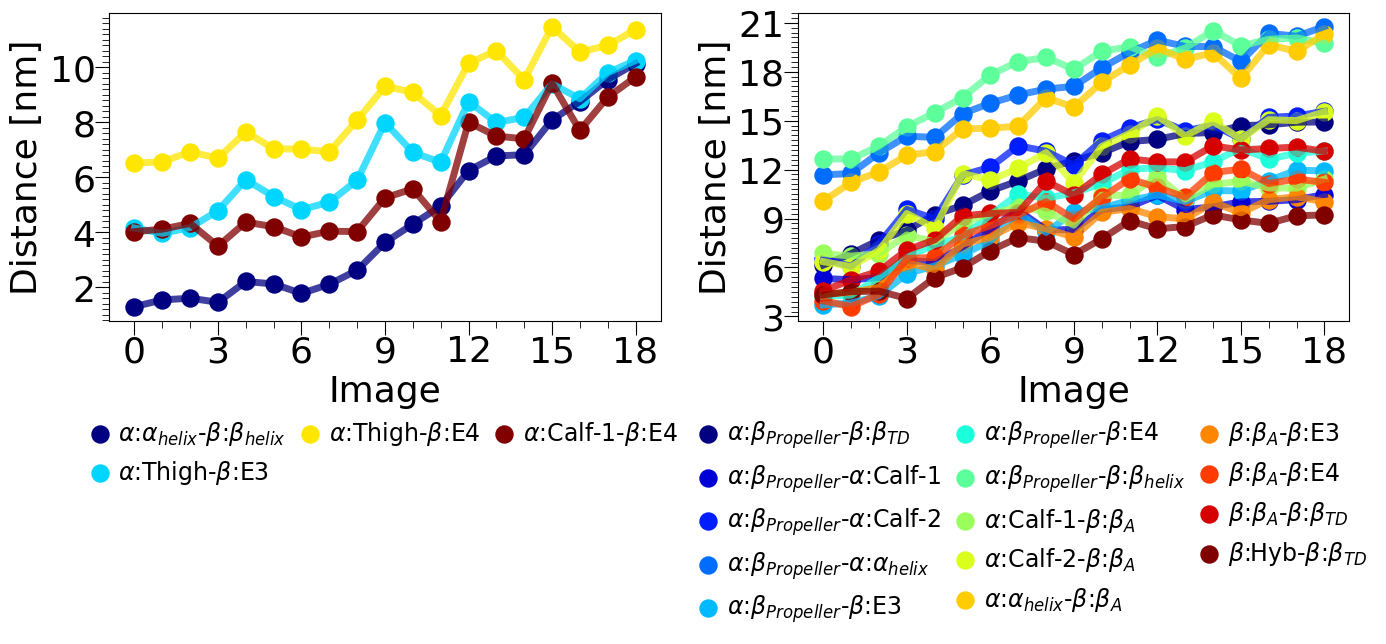

In [61]:
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator, MultipleLocator, AutoMinorLocator

font = {'weight' : 'normal',
        'size'   : 26}

plt.rc('font', **font)


fig = plt.figure(figsize=(16,4))

# Function to get the index of a key
def get_key_index(d, key):
    keys_list = list(d.keys())  # Convert keys to a list
    if key in keys_list:
        return keys_list.index(key)  # Return the index
    else:
        return -1  # Return -1 if the key is not found



rows=1
cols=2

count_figs = 0
gs = gridspec.GridSpec(rows, cols, hspace=0.3, wspace=0.25)


# Choose a colormap
cmap = plt.get_cmap('jet')

for i, key in enumerate(collect_interesting_keys):


    ncolors = len(collect_interesting_keys[key])+1
    values = np.linspace(0, 1, ncolors)
    colors = cmap(values)


    ax = fig.add_subplot(gs[i])

    ax.plot(np.arange(len(plot_yvals[key])), plot_yvals[key], color=colors[0],lw=5, alpha=0.75)
    ax.scatter(np.arange(len(plot_yvals[key])), plot_yvals[key], 
               color=colors[0],s=150, alpha=1, label=plot_xlabels[get_key_index(plot_yvals, key)])
    

    for j, inner_key in enumerate(collect_interesting_keys[key]):
        
        ax.plot(np.arange(len(plot_yvals[inner_key])), plot_yvals[inner_key], color=colors[j+1],lw=5, alpha=0.75)
        ax.scatter(np.arange(len(plot_yvals[inner_key])), plot_yvals[inner_key], 
                   color=colors[j+1],s=150, alpha=1, label=plot_xlabels[get_key_index(plot_yvals, inner_key)])

    ax.tick_params(axis='y', which='major', length=10, pad=0)
    ax.tick_params(axis='x', which='major', length=10, pad=0)
    ax.tick_params(axis='y', which='minor', length=5)
    ax.tick_params(axis='x', which='minor', length=5)

    ax.xaxis.set_major_locator(MultipleLocator(3))
    ax.xaxis.set_minor_locator(AutoMinorLocator(n=3))
    ax.yaxis.set_major_locator(MaxNLocator(7))    
    ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))   
    
    ax.set_ylabel('Distance [nm]')
    ax.set_xlabel(r'Image')# [$\alpha$]')

#     ax.plot(np.arange(len(plot_yvals[plot_xvals_group[i]])), plot_yvals[plot_xvals_group[i]],
#            lw=10, alpha=0.75, color=colors[color_index])
#     ax.scatter(np.arange(len(plot_yvals[plot_xvals_group[i]])), plot_yvals[plot_xvals_group[i]],
#            s=150, alpha=1, label=plot_xlabels_group[i], color=colors[color_index])  
# #     ticks=list(np.arange(len(plot_xvals)))

# #     ax.set_xticks(ticks=ticks)
#     #ax.set_xticklabels(labels=plot_xlabels, rotation=0, ha='right', fontsize=12)

#     #ax.set_title(plot_xlabels[i])


    ax.legend(frameon=False, fontsize=17, handlelength=0, bbox_to_anchor=(1.07, -0.25), ncol=3, columnspacing=1)

# # ax.set_ylim(-3,6*np.shape(single_r2_x_values)[0]-1)
# # ax.set_xlim(0,0.4)

#     color_index+=1
    
    

## Manuscript figure

In [62]:
# filter or select only few domains

# collect_interesting_keys_selected = {}

# for key in collect_interesting_keys:
    
#     if key in ['alpha_transmembrane_com-beta_transmembrane_com']:
        
#         filtered_list = []
#         for j in collect_interesting_keys[key]:
            
#             if j in ['thigh_com-e3_com', 'thigh_com-e4_com', 'calf_1_com-e4_com']:
                
#                 filtered_list.append(j)
                
#         collect_interesting_keys_selected[key] = filtered_list
            
#     else:
        
#         filtered_list = []
#         for j in collect_interesting_keys[key]:
            
#             if j in ['beta_propeller_com-beta_t_com', 'alpha_transmembrane_com-beta_1_com']:
                
#                 filtered_list.append(j)
                
#         collect_interesting_keys_selected[key] = filtered_list
        
# collect_interesting_keys_selected   
                

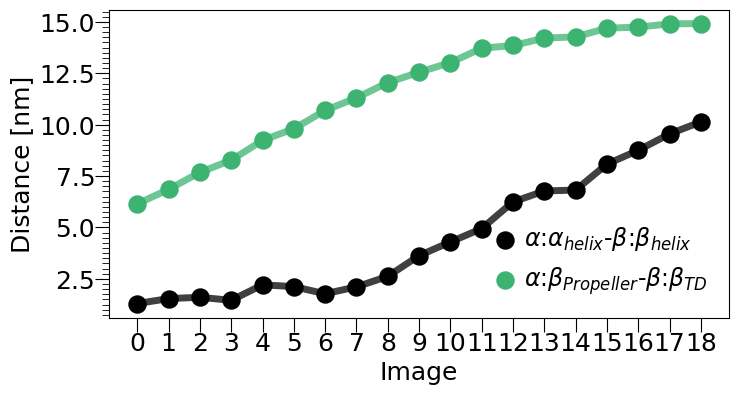

In [63]:
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator, MultipleLocator, AutoMinorLocator

font = {'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)


fig = plt.figure(figsize=(8,4))

# Function to get the index of a key
def get_key_index(d, key):
    keys_list = list(d.keys())  # Convert keys to a list
    if key in keys_list:
        return keys_list.index(key)  # Return the index
    else:
        return -1  # Return -1 if the key is not found



rows=1
cols=1

count_figs = 0
gs = gridspec.GridSpec(rows, cols, hspace=0.3, wspace=0.25)


# Choose a colormap
cmap = plt.get_cmap('jet')

ax = fig.add_subplot(gs[0])


ncolors = 2 #6
values = np.linspace(0, 1, ncolors)
colors = cmap(values)

# colors = ['darkred', 'darkgreen']
colors = ['black', 'mediumseagreen']


count_l=0
for i, key in enumerate(collect_interesting_keys):



#     ax = fig.add_subplot(gs[i])

    ax.plot(np.arange(len(plot_yvals[key])), plot_yvals[key], color=colors[count_l],lw=5, alpha=0.75)
    ax.scatter(np.arange(len(plot_yvals[key])), plot_yvals[key], 
               color=colors[count_l],s=150, alpha=1, label=plot_xlabels[get_key_index(plot_yvals, key)])
    
    count_l+=1
    
#     for j, inner_key in enumerate(collect_interesting_keys_selected[key]):
        
#         print(count_l)
        
#         ax.plot(np.arange(len(plot_yvals[inner_key])), plot_yvals[inner_key], color=colors[count_l],lw=5,
#                 alpha=0.25)
#         ax.scatter(np.arange(len(plot_yvals[inner_key])), plot_yvals[inner_key], 
#                    color=colors[count_l],s=150, alpha=0.25, 
#                    label=plot_xlabels[get_key_index(plot_yvals, inner_key)])
        
#         count_l+=1
        

    ax.tick_params(axis='y', which='major', length=10, pad=0)
    ax.tick_params(axis='x', which='major', length=10, pad=0)
    ax.tick_params(axis='y', which='minor', length=5)
    ax.tick_params(axis='x', which='minor', length=5)

    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_minor_locator(AutoMinorLocator(n=1))
    ax.yaxis.set_major_locator(MaxNLocator(7))    
    ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))   
    
    ax.set_ylabel('Distance [nm]')
    ax.set_xlabel(r'Image')# [$\alpha$]')

#     ax.plot(np.arange(len(plot_yvals[plot_xvals_group[i]])), plot_yvals[plot_xvals_group[i]],
#            lw=10, alpha=0.75, color=colors[color_index])
#     ax.scatter(np.arange(len(plot_yvals[plot_xvals_group[i]])), plot_yvals[plot_xvals_group[i]],
#            s=150, alpha=1, label=plot_xlabels_group[i], color=colors[color_index])  
# #     ticks=list(np.arange(len(plot_xvals)))

# #     ax.set_xticks(ticks=ticks)
#     #ax.set_xticklabels(labels=plot_xlabels, rotation=0, ha='right', fontsize=12)

#     #ax.set_title(plot_xlabels[i])


    ax.legend(frameon=False, fontsize=17, handlelength=0)#, bbox_to_anchor=(1.07, -0.25), ncol=3, columnspacing=1)

# # ax.set_ylim(-3,6*np.shape(single_r2_x_values)[0]-1)
# # ax.set_xlim(0,0.4)

#     color_index+=1
    
    

## Make a plot showing correlated domain pairs with the plot above

In [71]:
cutoff = 0.95 #.95

target_interesting_keys = {}
target_interesting_values = {}

for target in ['alpha_transmembrane_com-beta_transmembrane_com', 'beta_propeller_com-beta_t_com']:

    t_list_keys = []
    t_correlation_values = []
    for outer_key in distance_correlations:

        for inner_key in distance_correlations[outer_key]:

            if outer_key == target or inner_key == target:

                if np.abs(distance_correlations[outer_key][inner_key]) > cutoff:
                

                    #print(outer_key, inner_key, distance_correlations[outer_key][inner_key])

                    if outer_key == target:

                        t_list_keys.append(inner_key)
                        t_correlation_values.append(distance_correlations[outer_key][inner_key])

                    if inner_key  == target:

                        t_list_keys.append(outer_key)
                        t_correlation_values.append(distance_correlations[outer_key][inner_key])
                    
      
    target_interesting_keys[target] = t_list_keys
    target_interesting_values[target] = t_correlation_values
    
                
       

In [72]:
# list(zip(target_interesting_keys['beta_propeller_com-beta_t_com'], target_interesting_values['beta_propeller_com-beta_t_com']))
# target_interesting_keys['alpha_transmembrane_com-beta_transmembrane_com']
# pair_labels[target_interesting_keys['alpha_transmembrane_com-beta_transmembrane_com'][0]]

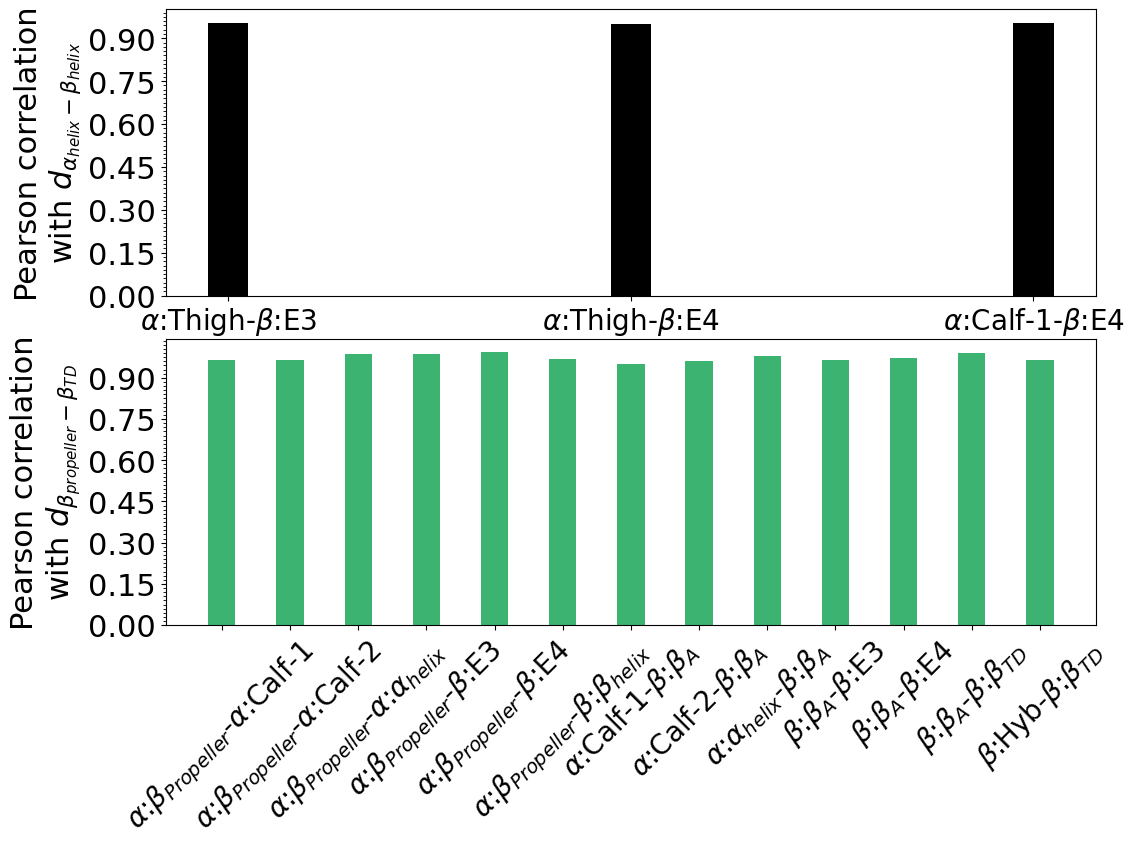

In [85]:
atmlabels=[]
for i in target_interesting_keys['alpha_transmembrane_com-beta_transmembrane_com']:
    atmlabels.append(pair_labels[i])
atmvals=target_interesting_values['alpha_transmembrane_com-beta_transmembrane_com']

btmlabels=[]
for i in target_interesting_keys['beta_propeller_com-beta_t_com']:
    btmlabels.append(pair_labels[i])
btmvals=target_interesting_values['beta_propeller_com-beta_t_com']

################################################################################################

font = {'weight' : 'normal',
        'size'   : 22}

plt.rc('font', **font)


fig = plt.figure(figsize=(12,8))

# Function to get the index of a key
def get_key_index(d, key):
    keys_list = list(d.keys())  # Convert keys to a list
    if key in keys_list:
        return keys_list.index(key)  # Return the index
    else:
        return -1  # Return -1 if the key is not found


rows=2
cols=1

count_figs = 0
gs = gridspec.GridSpec(rows, cols, hspace=0.15, wspace=0.25)

colors = ['black', 'mediumseagreen']

ax = fig.add_subplot(gs[0])

width = 0.1

ax.bar(atmlabels, atmvals, width, color=colors[0])
ax.set_xticks(np.arange(len(atmlabels)))
_ = ax.set_xticklabels(atmlabels, rotation=0, fontsize=20)

#$d_{\alpha_{helix}-\beta_{helix}}$ and $d_{\beta_{propeller}-\beta_{TD}}$
ax.set_ylabel(r'Pearson correlation'+ '\n' + r'with $d_{\alpha_{helix}-\beta_{helix}}$')
ax.yaxis.set_major_locator(MaxNLocator(10))    
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))

ax = fig.add_subplot(gs[1])

width = 0.4

ax.bar(btmlabels, btmvals, width, color=colors[1])
ax.set_xticks(np.arange(len(btmlabels)))
_ = ax.set_xticklabels(btmlabels, rotation=45, fontsize=20)

ax.set_ylabel(r'Pearson correlation'+ '\n' + r'with $d_{\beta_{propeller}-\beta_{TD}}$')
ax.yaxis.set_major_locator(MaxNLocator(10))    
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))

In [67]:
cutoff = 0 #.95

target_interesting_keys = {}
target_interesting_values = {}

for target in ['alpha_transmembrane_com-beta_transmembrane_com', 'beta_propeller_com-beta_t_com']:

    t_list_keys = []
    t_correlation_values = []
    for outer_key in distance_correlations:

        for inner_key in distance_correlations[outer_key]:

            if outer_key == target or inner_key == target:

                if np.abs(distance_correlations[outer_key][inner_key]) > cutoff:
                

                    #print(outer_key, inner_key, distance_correlations[outer_key][inner_key])

                    if outer_key == target:

                        t_list_keys.append(inner_key)
                        t_correlation_values.append(distance_correlations[outer_key][inner_key])

                    if inner_key  == target:

                        t_list_keys.append(outer_key)
                        t_correlation_values.append(distance_correlations[outer_key][inner_key])
                    
      
    target_interesting_keys[target] = t_list_keys
    target_interesting_values[target] = t_correlation_values
    
                
       

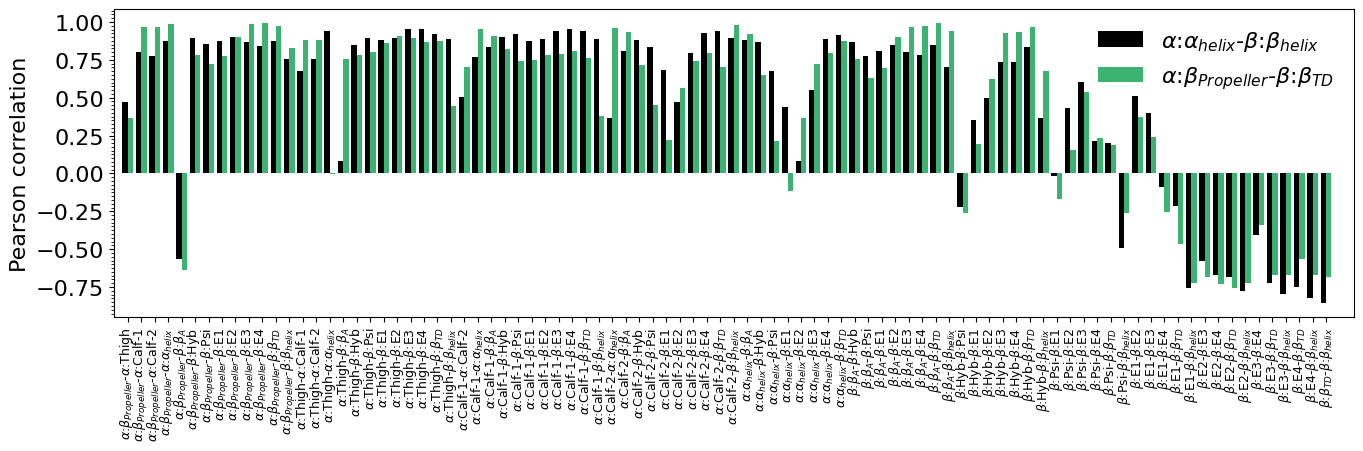

In [68]:
atmlabels=[]
for i in target_interesting_keys['alpha_transmembrane_com-beta_transmembrane_com']:
    atmlabels.append(pair_labels[i])
atmvals=target_interesting_values['alpha_transmembrane_com-beta_transmembrane_com']

btmlabels=[]
for i in target_interesting_keys['beta_propeller_com-beta_t_com']:
    btmlabels.append(pair_labels[i])
btmvals=target_interesting_values['beta_propeller_com-beta_t_com']

################################################################################################

font = {'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)


fig = plt.figure(figsize=(16,4))

# Function to get the index of a key
def get_key_index(d, key):
    keys_list = list(d.keys())  # Convert keys to a list
    if key in keys_list:
        return keys_list.index(key)  # Return the index
    else:
        return -1  # Return -1 if the key is not found


rows=1
cols=1

count_figs = 0
gs = gridspec.GridSpec(rows, cols, hspace=0.3, wspace=0.25)

colors = ['black', 'mediumseagreen']

ax = fig.add_subplot(gs[0])

xlabels = np.arange(len(atmlabels))
width = 0.4

ax.bar(xlabels - width/2, atmvals, width, color=colors[0], label=plot_xlabels[get_key_index(pair_labels, 'alpha_transmembrane_com-beta_transmembrane_com')])
ax.bar(xlabels + width/2, btmvals, width, color=colors[1], label=plot_xlabels[get_key_index(pair_labels, 'beta_propeller_com-beta_t_com')])

ax.set_xticks(np.arange(len(atmlabels)))
_ = ax.set_xticklabels(atmlabels, rotation=90, fontsize=9)

ax.set_xlim(-1.05, len(atmlabels)+1.05)

ax.set_ylabel('Pearson correlation')

ax.legend(frameon=False,loc='upper right')

ax.yaxis.set_major_locator(MaxNLocator(10))    
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10)) 


In [38]:
# distance_correlations

In [33]:
# cutoff = 0.6

# collect_interesting_keys = {}

# for target in ['alpha_transmembrane_com-beta_transmembrane_com', 'beta_propeller_com-beta_t_com']:

#     list_keys = []
#     for outer_key in distance_correlations:

#         for inner_key in distance_correlations[outer_key]:

#             if outer_key == target or inner_key == target:

#                 #if np.abs(distance_correlations[outer_key][inner_key]) > cutoff:
#                 if distance_correlations[outer_key][inner_key] < -cutoff:
                

#                     #print(outer_key, inner_key, distance_correlations[outer_key][inner_key])

#                     if outer_key == target:

#                         list_keys.append(inner_key)

#                     if inner_key  == target:

#                         list_keys.append(outer_key)
      
#     collect_interesting_keys[target] = list_keys
    
                
# collect_interesting_keys                
       

In [34]:
# import matplotlib.gridspec as gridspec
# from matplotlib.ticker import MaxNLocator, MultipleLocator, AutoMinorLocator

# font = {'weight' : 'normal',
#         'size'   : 26}

# plt.rc('font', **font)


# fig = plt.figure(figsize=(16,4))

# # Function to get the index of a key
# def get_key_index(d, key):
#     keys_list = list(d.keys())  # Convert keys to a list
#     if key in keys_list:
#         return keys_list.index(key)  # Return the index
#     else:
#         return -1  # Return -1 if the key is not found



# rows=1
# cols=2

# count_figs = 0
# gs = gridspec.GridSpec(rows, cols, hspace=0.3, wspace=0.3)


# # Choose a colormap
# cmap = plt.get_cmap('jet')

# for i, key in enumerate(collect_interesting_keys):


#     ncolors = len(collect_interesting_keys[key])+1
#     values = np.linspace(0, 1, ncolors)
#     colors = cmap(values)


#     ax = fig.add_subplot(gs[i])

#     ax.plot(np.arange(len(plot_yvals[key])), plot_yvals[key], color=colors[0],lw=5, alpha=0.75)
#     ax.scatter(np.arange(len(plot_yvals[key])), plot_yvals[key], 
#                color=colors[0],s=150, alpha=1, label=plot_xlabels[get_key_index(plot_yvals, key)])
    

#     for j, inner_key in enumerate(collect_interesting_keys[key]):
        
#         ax.plot(np.arange(len(plot_yvals[inner_key])), plot_yvals[inner_key], color=colors[j+1],lw=5, alpha=0.75)
#         ax.scatter(np.arange(len(plot_yvals[inner_key])), plot_yvals[inner_key], 
#                    color=colors[j+1],s=150, alpha=1, label=plot_xlabels[get_key_index(plot_yvals, inner_key)])

#     ax.tick_params(axis='y', which='major', length=10, pad=0)
#     ax.tick_params(axis='x', which='major', length=10, pad=0)
#     ax.tick_params(axis='y', which='minor', length=5)
#     ax.tick_params(axis='x', which='minor', length=5)

#     ax.xaxis.set_major_locator(MultipleLocator(3))
#     ax.xaxis.set_minor_locator(AutoMinorLocator(n=3))
#     ax.yaxis.set_major_locator(MaxNLocator(7))    
#     ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))   
    
#     ax.set_ylabel('Distance [nm]')
#     ax.set_xlabel(r'Image')# [$\alpha$]')

# #     ax.plot(np.arange(len(plot_yvals[plot_xvals_group[i]])), plot_yvals[plot_xvals_group[i]],
# #            lw=10, alpha=0.75, color=colors[color_index])
# #     ax.scatter(np.arange(len(plot_yvals[plot_xvals_group[i]])), plot_yvals[plot_xvals_group[i]],
# #            s=150, alpha=1, label=plot_xlabels_group[i], color=colors[color_index])  
# # #     ticks=list(np.arange(len(plot_xvals)))

# # #     ax.set_xticks(ticks=ticks)
# #     #ax.set_xticklabels(labels=plot_xlabels, rotation=0, ha='right', fontsize=12)

# #     #ax.set_title(plot_xlabels[i])


#     ax.legend(frameon=False, fontsize=17, handlelength=0, bbox_to_anchor=(1.1, -0.25), ncol=3, columnspacing=1)

# # # ax.set_ylim(-3,6*np.shape(single_r2_x_values)[0]-1)
# # # ax.set_xlim(0,0.4)


    

    
# #     color_index+=1
    
    